# <font color='darkblue'>Setup</font> 

## <font color='orange'>Packages</font> 

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter
import datetime as dt
from scipy.interpolate import griddata

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
import cmocean

# Timing Processes and Progress
import time
from tqdm import tqdm
import itertools

# make sure the figures plot inline rather than at the end
%matplotlib inline

## <font color='orange'>Functions</font> 

In [2]:
# filtering a 2D matrix ---------------------------------------------------------------#
def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# put coastlines on map and set xy limits ---------------------------------------------#
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

# mask coastlines ---------------------------------------------------------------------#
def mask_coast(c_lon,c_lat,bounds):
    data=xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/pco2_flux_coastal_Roobaert/mask_ocean.nc')
    mask_coast=np.array(data.mask_coastal2).astype(int).T
    lat=np.array(data.latitude)
    lon=np.array(data.longitude)

    mask_lon=np.logical_and(lon>bounds[0],lon<bounds[1])
    mask_lat=np.logical_and(lat>bounds[2],lat<bounds[3])

    lon=lon[mask_lon]
    lat=lat[mask_lat]

    mask_coast=mask_coast[mask_lat]
    mask_coast=mask_coast[:,mask_lon]

    lonlon,latlat=np.meshgrid(lon,lat)

    # what are these for? I should probably fix it
    lon_dot=np.array([70,70])
    lat_dot=np.array([10,19.5])

    mask=[]
    for lo,la in zip(c_lon,c_lat):
        if len(lon[lon<=lo])>0 and len(lat[lat>=la])>0 and len(lon[lon>=lo])>0 and len(lat[lat<=la])>0:
            lon_lim=[lon[lon<=lo][-1],lon[lon>=lo][0]]
            lat_lim=[lat[lat<=la][-1],lat[lat>=la][0]]
            mask_lon=np.logical_or(lon==lon_lim[0],lon==lon_lim[1])
            mask_lat=np.logical_or(lat==lat_lim[0],lat==lat_lim[1])
            mask_tmp=mask_coast[mask_lat]
            mask_tmp=mask_tmp[:,mask_lon]
            mask.append(np.mean(mask_tmp)>0)
        else:
            mask.append(False)
    mask=np.array(mask)
    return mask

## <font color='orange'>Read Data</font> 

In [3]:
# WOA
path_WOA = '../data/WOA/'
infn_WOA = 'woa_grid_processed.nc'

ds_WOA = xr.open_dataset(path_WOA + infn_WOA)

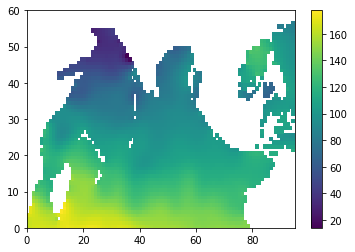

In [4]:
plt.pcolormesh(ds_WOA.doxy_grid[0,-1,:,:])
plt.colorbar()

# <font color='darkblue'>Find WOA TCD, OCD, HCD</font> 

In [5]:
TCP = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
OCP = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
HCP = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

TCP_thresh_20 = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
OCP_thresh_50 = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
TCP_thresh_23 = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
OCP_thresh_100 = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
TCP_thresh_25 = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
OCP_thresh_150 = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

# mean temperature and doxy in water column
doxy_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
temp_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

doxy_TCP_bot_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
temp_TCP_bot_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

doxy_TCP_200_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
temp_TCP_200_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

doxy_10_50_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
temp_10_50_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

doxy_50_200_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
temp_50_200_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

doxy_10_200_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
temp_10_200_mean = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

# minimum oxygen and temp values
doxy_min = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
temp_min = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

# median oxygen and temp values
doxy_median = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)
temp_median = np.full((ds_WOA.month.shape[0],ds_WOA.lat.shape[0],ds_WOA.lon.shape[0]),np.nan)

n = len(ds_WOA.month)
m = len(ds_WOA.lat)
p = len(ds_WOA.lon)

with tqdm(total=n * m * p) as pbar:
    for tt,ii,jj in itertools.product(np.arange(len(ds_WOA.month)),np.arange(len(ds_WOA.lat)),np.arange(len(ds_WOA.lon))):
        temp = np.array(ds_WOA.temp_grid[tt,:,ii,jj])
        doxy = np.array(ds_WOA.doxy_grid[tt,:,ii,jj])
        psal = np.array(ds_WOA.psal_grid[tt,:,ii,jj])
        pres = np.array(ds_WOA.pres_grid[:,ii,jj])
#         pres = np.array(ds_WOA.pres)
#         depth = ds_WOA.depth

        # gradient method -----------------------------------------#

        # only take upper 10-500dbar of data
        ind = (pres>=10) & (pres<=500)
        upper_temp = temp[ind]
        upper_doxy = doxy[ind]
        upper_psal = psal[ind]
        upper_pres = pres[ind]

        # find gradients, min/max gradient inds, and pressure at min inds
        if np.nansum(~np.isnan(upper_temp)) >= 10: 
            temp_grad = np.gradient(upper_temp,upper_pres)
            # note that nanargmin automatically takes the value closest to the surface
            temp_grad_max_ind = np.nanargmax(np.abs(temp_grad))
            TCP[tt,ii,jj] = upper_pres[temp_grad_max_ind]
            
        if np.nansum(~np.isnan(upper_doxy)) >= 10: 
            doxy_grad = np.gradient(upper_doxy,upper_pres)
            doxy_grad_max_ind = np.nanargmax(np.abs(doxy_grad))
            OCP[tt,ii,jj] = upper_pres[doxy_grad_max_ind]
            
        if np.nansum(~np.isnan(upper_psal)) >= 10: 
            psal_grad = np.gradient(upper_psal,upper_pres)
            psal_grad_max_ind = np.nanargmax(np.abs(psal_grad)) 
            HCP[tt,ii,jj] = upper_pres[psal_grad_max_ind]

        # threshold method -----------------------------------------#
        doxy_thresh = 100
        temp_thresh = 23
        
        temp_ind = temp <= temp_thresh
        if len(pres[temp_ind]) > 0: 
            TCP_thresh_23[tt,ii,jj] = pres[temp_ind][0]
            
        doxy_ind = doxy <= doxy_thresh
        if len(pres[doxy_ind]) > 0: 
            OCP_thresh_100[tt,ii,jj] = pres[doxy_ind][0]
        
        doxy_thresh = 50
        temp_thresh = 20
        
        temp_ind = temp <= temp_thresh
        if len(pres[temp_ind]) > 0: 
            TCP_thresh_20[tt,ii,jj] = pres[temp_ind][0]
            
        doxy_ind = doxy <= doxy_thresh
        if len(pres[doxy_ind]) > 0: 
            OCP_thresh_50[tt,ii,jj] = pres[doxy_ind][0]
        
        doxy_thresh = 150
        temp_thresh = 25
        
        temp_ind = temp <= temp_thresh
        if len(pres[temp_ind]) > 0: 
            TCP_thresh_25[tt,ii,jj] = pres[temp_ind][0]
            
        doxy_ind = doxy <= doxy_thresh
        if len(pres[doxy_ind]) > 0: 
            OCP_thresh_150[tt,ii,jj] = pres[doxy_ind][0]

        # find water column averages -------------------------------#
        
        TCPtmp = np.array(TCP[tt,ii,jj])
        OCPtmp = np.array(OCP[tt,ii,jj])
        
        if ~np.isnan(TCPtmp): # if TCP/OCPtmp is a nan it already has less than 10 pts above 500dbar
                
            if TCPtmp < 200:
                # find mean temperature and doxy TCP-200dbar
                ind = (pres>= TCPtmp) & (pres<= 200)
                print(pres[ind])
                temp_TCP_200_mean[tt,ii,jj] = np.nanmean(temp[ind])
                doxy_TCP_200_mean[tt,ii,jj] = np.nanmean(doxy[ind])
    
            # find mean temperature and doxy TCP-bottom
            ind = (pres>= TCPtmp)
            temp_TCP_bot_mean[tt,ii,jj] = np.nanmean(temp[ind])
            doxy_TCP_bot_mean[tt,ii,jj] = np.nanmean(doxy[ind])
                
            # find mean temperature and doxy top-bottom
            temp_mean[tt,ii,jj] = np.nanmean(temp)
            doxy_mean[tt,ii,jj] = np.nanmean(doxy)

            # find mean temperature and doxy 10-50dbar
            ind = (pres>= 10) & (pres<= 50)
            temp_10_50_mean[tt,ii,jj] = np.nanmean(temp[ind])
            doxy_10_50_mean[tt,ii,jj] = np.nanmean(doxy[ind])

            # find mean temperature and doxy 50-200dbar
            ind = (pres>= 50) & (pres<= 200)
            temp_50_200_mean[tt,ii,jj] = np.nanmean(temp[ind])
            doxy_50_200_mean[tt,ii,jj] = np.nanmean(doxy[ind])

            # find mean temperature and doxy 10-200dbar
            ind = (pres>= 10) & (pres<= 200)
            temp_10_200_mean[tt,ii,jj] = np.nanmean(temp[ind])
            doxy_10_200_mean[tt,ii,jj] = np.nanmean(doxy[ind])

            # find min temperature and doxy 
            temp_min[tt,ii,jj] = np.nanmin(temp)
            doxy_min[tt,ii,jj] = np.nanmin(doxy)

            # find min temperature and doxy 
            temp_median[tt,ii,jj] = np.nanmedian(temp)
            doxy_median[tt,ii,jj] = np.nanmedian(doxy)

    
        pbar.update(1)
    

  0%|          | 21/68400 [00:00<05:39, 201.21it/s]

[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 40.29381943  45.3372879   50.36727142  55.41074371  60.44072723
  65.48419952  70.51418304  75.55764771  80.60112     85.63110352
  90.67457581  95.7180481  100.74803162 125.9384079  151.14227295
 176.33265686]
[ 40.29381943  45.3372879   50.36727142  55.41074371  60.44072723
  65.48419952  70.51418304  75.55764771  80.60112     85.63110352
  90.67457581  95.7180481  100.74803162 125.9384079  151.14227295
 176.33265686]
[ 40.29381943  45.3

  0%|          | 63/68400 [00:00<05:37, 202.45it/s]/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in less_equal
  0%|          | 84/68400 [00:00<05:34, 204.08it/s]

[ 30.22036362  35.26383209  40.29381943  45.3372879   50.36727142
  55.41074371  60.44072723  65.48419952  70.51418304  75.55764771
  80.60112     85.63110352  90.67457581  95.7180481  100.74803162
 125.9384079  151.14227295 176.33265686]
[ 30.22036362  35.26383209  40.29381943  45.3372879   50.36727142
  55.41074371  60.44072723  65.48419952  70.51418304  75.55764771
  80.60112     85.63110352  90.67457581  95.7180481  100.74803162
 125.9384079  151.14227295 176.33265686]
[ 30.22036362  35.26383209  40.29381943  45.3372879   50.36727142
  55.41074371  60.44072723  65.48419952  70.51418304  75.55764771
  80.60112     85.63110352  90.67457581  95.7180481  100.74803162
 125.9384079  151.14227295 176.33265686]
[ 35.26383209  40.29381943  45.3372879   50.36727142  55.41074371
  60.44072723  65.48419952  70.51418304  75.55764771  80.60112
  85.63110352  90.67457581  95.7180481  100.74803162 125.9384079
 151.14227295 176.33265686]
[ 35.26383209  40.29381943  45.3372879   50.36727142  55.4107

  0%|          | 128/68400 [00:00<05:28, 208.13it/s]

[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 40.29381943  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 40.29381943  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 40.29381943  4

  0%|          | 170/68400 [00:00<05:30, 206.28it/s]

[ 30.22036362  35.26383209  40.29381943  45.32380295  50.36727142
  55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.63110352  90.66108704  95.70455933 100.74803162
 125.9384079  151.12878418 176.31916809]
[ 30.22036362  35.26383209  40.29381943  45.32380295  50.36727142
  55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.63110352  90.66108704  95.70455933 100.74803162
 125.9384079  151.12878418 176.31916809]
[ 30.22036362  35.26383209  40.29381943  45.32380295  50.36727142
  55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.63110352  90.66108704  95.70455933 100.74803162
 125.9384079  151.12878418 176.31916809]
[ 35.26383209  40.29381943  45.32380295  50.36727142  55.39725876
  60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]
[ 35.26383209  40.29381943  45.32380295  50.36727142  55.3

  0%|          | 215/68400 [00:01<05:23, 210.79it/s]

[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.61762238  90.66108704  95.70455933
 100.73454285 125.92492676 151.11529541 176.30567932]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.61762238  90.66108704  95.70455933
 100.73454285 125.92492676 151.11529541 176.30567932]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.61762238  90.66108704  95.70455933
 100.73454285 125.92492676 151.11529541 176.30567932]
[ 40.28033447  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 40.28033447  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 40.28033447  4

  0%|          | 257/68400 [00:01<05:29, 207.09it/s]

[ 30.22036362  35.25034714  40.28033447  45.32380295  50.36727142
  55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 30.22036362  35.25034714  40.28033447  45.32380295  50.36727142
  55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 30.22036362  35.25034714  40.28033447  45.32380295  50.36727142
  55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 35.25034714  40.28033447  45.32380295  50.36727142  55.39725876
  60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.61762238  90.66108704  95.70455933 100.73454285 125.92492676
 151.11529541 176.30567932]
[ 35.25034714  40.28033447  45.32380295  50.36727142  55.

  0%|          | 324/68400 [00:01<05:24, 209.58it/s]

[ 50.35378647  55.39725876  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.69107819
 100.72106171 125.91143799 151.1018219  176.29219055]
[ 40.28033447  45.32380295  50.35378647  55.39725876  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.69107819 100.72106171 125.91143799 151.1018219
 176.29219055]
[ 40.28033447  45.32380295  50.35378647  55.39725876  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.69107819 100.72106171 125.91143799 151.1018219
 176.29219055]
[ 40.28033447  45.32380295  50.35378647  55.39725876  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.69107819 100.72106171 125.91143799 151.1018219
 176.29219055]
[ 40.28033447  45.32380295  50.35378647  55.39725876  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.69107819 100.72106171 125.91

  1%|          | 366/68400 [00:01<05:30, 206.03it/s]

[ 30.20687866  35.25034714  40.28033447  45.32380295  50.35378647
  55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 30.20687866  35.25034714  40.28033447  45.32380295  50.35378647
  55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 30.20687866  35.25034714  40.28033447  45.32380295  50.35378647
  55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 35.25034714  40.28033447  45.32380295  50.35378647  55.39725876
  60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 35.25034714  40.28033447  45.32380295  50.35378647  55.397

  1%|          | 412/68400 [00:01<05:20, 212.21it/s]

[ 35.25034714  40.28033447  45.32380295  50.35378647  55.38376999
  60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 35.25034714  40.28033447  45.32380295  50.35378647  55.38376999
  60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 40.28033447  45.32380295  50.35378647  55.38376999  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.67758942 100.72106171 125.91143799 151.1018219
 176.27871704]
[ 40.28033447  45.32380295  50.35378647  55.38376999  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.67758942 100.72106171 125.91143799 151.1018219
 176.27871704]
[ 40.28033447  45.32380295  50.35378647  55.38376999  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.6

  1%|          | 456/68400 [00:02<05:25, 208.80it/s]

[ 35.25034714  40.28033447  45.32380295  50.35378647  55.38376999
  60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 30.20687866  35.25034714  40.28033447  45.32380295  50.35378647
  55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.1018219  176.27871704]
[ 30.20687866  35.25034714  40.28033447  45.32380295  50.35378647
  55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.1018219  176.27871704]
[ 35.25034714  40.28033447  45.32380295  50.35378647  55.38376999
  60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 35.25034714  40.28033447  45.32380295  50.35378647  55.38376999
  60.4

  1%|          | 502/68400 [00:02<05:14, 215.65it/s]

[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 40.28033447  45.31031799  50.35378647  55.38376999  60.42724228
  65.45722961  70.48721313  75.5306778   80.56066895  85.60413361
  90.63411713  95.67758942 100.70757294 125.89794922 151.08833313
 176.26522827]
[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.60413361  90.63411713
  95.67758942 100.70757294 125.89794922 151.08833313 176.26522827]
[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.60413361  90.63411713
  95

  1%|          | 546/68400 [00:02<05:24, 208.78it/s]

[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95

  1%|          | 614/68400 [00:02<05:18, 213.05it/s]

[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.59065247  90.63411713
  95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.59065247  90.63411713
  95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.59065247  90.63411713
  95.67758942 100.

  1%|          | 636/68400 [00:03<05:22, 210.06it/s]

[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.59065247  90.63411713  95.67758942 100.70757294
 125.88446808 151.07484436 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.59065247  90.63411713  95.67758942 100.70757294
 125.88446808 151.07484436 176.26522827]
[ 55.38376999  6

  1%|          | 704/68400 [00:03<05:16, 214.11it/s]

[ 35.23686218  40.2668457   45.31031799  50.34030151  55.37028503
  60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 35.23686218  40.2668457   45.31031799  50.34030151  55.37028503
  60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.

  1%|          | 748/68400 [00:03<05:18, 212.13it/s]

[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 55.37028503  60.41375732  65.44374084  70.48721313  75.51719666
  80.54718018  85.5771637   90.62063599  95.66410065 100.6940918
 125.87097931 151.06135559 176.23825073]
[ 55.37028503  60.41375732  65.44374084  70.48721313  75.51719666
  80.54718018  85.5771637   90.62063599  95.66410065 100.6940918
 125.87097931 151.06135559 176.23825073]
[ 55.37028503  6

  1%|          | 794/68400 [00:03<05:13, 215.82it/s]

[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.

  1%|          | 838/68400 [00:03<05:20, 210.82it/s]

[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 55.37028503  60.41375732  65.44374084  70.48721313  75.51719666
  80.54718018  85.5771637   90.62063599  95.66410065 100.6940918
 125.87097931 151.06135559 176.23825073]
[ 50.34030151  55.37028503  60.41375732  65.44374084  70.48721313
  75.51719666  80.54718018  85.5771637   90.62063599  95.66410065
 100.6940918  125.87097931 151.06135559 176.23825073]
[ 

  1%|▏         | 884/68400 [00:04<05:11, 216.88it/s]

[ 45.29683304  50.34030151  55.37028503  60.40027237  65.43025208
  70.47372437  75.50370789  80.54718018  85.5771637   90.60714722
  95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 45.29683304  50.34030151  55.37028503  60.40027237  65.43025208
  70.47372437  75.50370789  80.54718018  85.5771637   90.60714722
  95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 45.29683304  50.34030151  55.37028503  60.40027237  65.43025208
  70.47372437  75.50370789  80.54718018  85.5771637   90.60714722
  95.65061951 100.68060303 125.85749817 151.04

  1%|▏         | 928/68400 [00:04<05:18, 211.54it/s]

[ 60.40027237  65.43025208  70.47372437  75.50370789  80.54718018
  85.5771637   90.60714722  95.65061951 100.68060303 125.85749817
 151.04788208 176.22476196]
[ 60.40027237  65.43025208  70.47372437  75.50370789  80.54718018
  85.5771637   90.60714722  95.65061951 100.68060303 125.85749817
 151.04788208 176.22476196]
[ 60.40027237  65.43025208  70.47372437  75.50370789  80.54718018
  85.5771637   90.60714722  95.65061951 100.68060303 125.85749817
 151.04788208 176.22476196]
[ 60.40027237  65.43025208  70.47372437  75.50370789  80.54718018
  85.5771637   90.60714722  95.65061951 100.68060303 125.85749817
 151.04788208 176.22476196]
[ 50.34030151  55.37028503  60.40027237  65.43025208  70.47372437
  75.50370789  80.54718018  85.5771637   90.60714722  95.65061951
 100.68060303 125.85749817 151.04788208 176.22476196]
[ 50.34030151  55.37028503  60.40027237  65.43025208  70.47372437
  75.50370789  80.54718018  85.5771637   90.60714722  95.65061951
 100.68060303 125.85749817 151.04788208 17

  1%|▏         | 974/68400 [00:04<05:10, 217.03it/s]

[ 35.23686218  40.2668457   45.29683304  50.34030151  55.37028503
  60.40027237  65.43025208  70.47372437  75.50370789  80.53369141
  85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.53369141  85.56368256
  90.60714722  95.65061951 100.68060303 125.85749817 151.03439331
 176.21128845]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.53369141  85.56368256
  90.60714722  95.65061951 100.68060303 125.85749817 151.03439331
 176.21128845]
[ 45.29683304  50.34030151  55.37028503  60.40027237  65.43025208
  70.47372437  75.50370789  80.53369141  85.56368256  90.60714722
  95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 50.34030151  55.37028503  60.40027237  65.43025208  70.47372437
  75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125

  1%|▏         | 1018/68400 [00:04<05:18, 211.29it/s]

[ 60.40027237  65.43025208  70.47372437  75.50370789  80.53369141
  85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 60.40027237  65.43025208  70.47372437  75.50370789  80.53369141
  85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 65.43025208  70.47372437  75.50370789  80.53369141  85.56368256
  90.60714722  95.65061951 100.68060303 125.85749817 151.03439331
 176.21128845]
[ 65.43025208  70.47372437  75.50370789  80.53369141  85.56368256
  90.60714722  95.65061951 100.68060303 125.85749817 151.03439331
 176.21128845]
[ 50.34030151  55.37028503  60.40027237  65.43025208  70.47372437
  75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 50.34030151  55.37028503  60.40027237  65.43025208  70.47372437
  75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 50.34030151 

  2%|▏         | 1086/68400 [00:05<05:14, 213.82it/s]

[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 50.32681656  55.35680008  60.40027237  65.43025208  70.46024323
  75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 12

  2%|▏         | 1130/68400 [00:05<05:20, 209.70it/s]

[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 50.32681656  55.35680008  60.40027237  65.43025208  70.46024323
  75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 50.32681656  55.35680008  60.40027237  65.43025208  70.46024323
  75.49022675

  2%|▏         | 1176/68400 [00:05<05:12, 214.87it/s]

[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 50.32681656  55.35680008  60.40027237  65.43025208  70.46024323
  75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 55.35680008  60.40027237  65.43025208  70.46024323  75.49022675
  80.53369141  85.56368256  90.59366608  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  

  2%|▏         | 1220/68400 [00:05<05:19, 210.30it/s]

[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 70.46024323  75.49022675 

  2%|▏         | 1266/68400 [00:05<05:08, 217.33it/s]

[ 35.22337723  40.25336075  45.29683304  50.32681656  55.35680008
  60.40027237  65.43025208  70.46024323  75.49022675  80.52021027
  85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 50.32681656  55.35680008  60.40027237  65.43025208  70.46024323
  75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[125.83052826 151.00741577 176.18431091]
[ 95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 65.43025208  70.46024323  75.49022675  80.52021027  85.56368256
  90.59366608  9

  2%|▏         | 1310/68400 [00:06<05:16, 211.98it/s]

[ 70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 90.59366608  95.63713074 100.66712189 

  2%|▏         | 1378/68400 [00:06<05:11, 214.82it/s]

[ 50.32681656  55.35680008  60.38678741  65.41677094  70.46024323
  75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.46024323
  75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 60.38678741  65.41677094  70.46024323  75.49022675  80.52021027
  85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 45.28334808  50.32681656  55.35680008  60.38678741  65.41677094
  70.46024323  75.49022675  80.52021027  85.55019379  90.59366608
  95.6236496  100.65363312 125.83052826 151.00741577 176.17082214]
[ 45.28334808  50.32681656  55.35680008  60.38678741  65.41677094
  70.46024323  75.49022675  80.52021027  85.55019379  90

  2%|▏         | 1422/68400 [00:06<05:14, 212.87it/s]

[ 70.46024323  75.49022675  80.52021027  85.55019379  90.59366608
  95.6236496  100.65363312 125.83052826 151.00741577 176.17082214]
[ 70.46024323  75.49022675  80.52021027  85.55019379  90.59366608
  95.6236496  100.65363312 125.83052826 151.00741577 176.17082214]
[125.83052826 151.00741577 176.17082214]
[125.83052826 151.00741577 176.17082214]
[125.83052826 151.00741577 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.

  2%|▏         | 1468/68400 [00:06<05:11, 214.56it/s]

[150.99394226 176.17082214]
[150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.46024323
  75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.46024323
  75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.46024323
  75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.17082214]
[ 45.28334808  50.32681656  55.35680008  60.38678741  65.41677094
  70.46024323  75.49022675  80.52021027  85.55019379  90.58017731
  95.6236496  100.65363312 125.81703949 150.99394226 176.17082214]
[ 45.28334808  50.32681656  55.35680008  60.38678741  65.41677094
  7

  2%|▏         | 1512/68400 [00:07<05:18, 209.95it/s]

[ 70.46024323  75.49022675  80.52021027  85.55019379  90.58017731
  95.6236496  100.65363312 125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 1

  2%|▏         | 1558/68400 [00:07<05:13, 213.10it/s]

[150.99394226 176.15734863]
[150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[ 55.35680008  60.38678741  65.41677094  70.44675446  75.47673798
  80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.15734863]
[ 65.41677094  70.44675446  75.47673798  80.52021027  85.55019379
  90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.44675446
  75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.44675446
  75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 65.41677094  70.44675446  75.47673798  80.52021027  85.55019379


  2%|▏         | 1602/68400 [00:07<05:17, 210.36it/s]

[100.65363312 125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863

  2%|▏         | 1646/68400 [00:07<05:15, 211.76it/s]

[ 95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 70.44675446  75.47673798  80.52021027  85.55019379  90.58017731
  95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[150.98045349 176.15734863]
[150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[ 60.38678741  65.41677094  70.44675446  75.47673798  80.5067215
  85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.81703949 150.98045349
 176.15734863]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.81703949 150.98045349
 176.15734863]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.81703949

  2%|▏         | 1689/68400 [00:07<05:18, 209.66it/s]

[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[ 75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[ 75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[ 75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[

  3%|▎         | 1732/68400 [00:08<05:18, 209.02it/s]

[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 9

  3%|▎         | 1774/68400 [00:08<05:22, 206.69it/s]

[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.80355835 150.98045349 176.14385986]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85

  3%|▎         | 1817/68400 [00:08<05:22, 206.56it/s]

[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.

  3%|▎         | 1859/68400 [00:08<05:27, 203.20it/s]

[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.56669617
  95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.56669617
  95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.56669617
  95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 40.25336075  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 1

  3%|▎         | 1902/68400 [00:08<05:21, 207.10it/s]

[ 75.47673798  80.5067215   85.53671265  90.56669617  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 75.47673798  80.5067215   85.53671265  90.56669617  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.9

  3%|▎         | 1945/68400 [00:09<05:18, 208.51it/s]

[100.62666321 125.80355835 150.96696472 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.53671265  90.56669617
  95.59667969 100.62666321 125.80355835 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.53671265  90.56669617
  95.59667969 100.62666321 125.80355835 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.53671265  90.56669617
  95.59667969 100.62666321 125.80355835 150.96696472 176.13037109]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.5067215   85.53671265  90.56669617
  95.59667969 100.62666321 125.80355835 150.96696472 176.13037109]
[ 45.28334808  50.3133316   55.34331512  60.37330246  

  3%|▎         | 1987/68400 [00:09<05:19, 208.11it/s]

[100.62666321 125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 80.5067215   85.53671265  90.56669617  95.59667969 100.62666321
 125.80355835 150.96696472 176.13037109]
[ 80.5067215   85.53671265  90.56669617  95.59667969 100.62666321
 125.80355835 150.96696472 176.13037109]
[ 80.5067215   85.53671265  90.56669617  95.59667969 100.62666321
 125.80355835 150.96696472 176.13037109]
[ 80.5067215   85.53671265  90.56669617  95.59667969 100.62666321
 125.80355835 150.96696472 176.13037109]
[ 75.46325684  80.5067215   85.53671265  90.56669617  95.59667969
 100.62666321 125.80355835 150.96696472 176.13037109]
[ 80.5067215   85.53671265  90.56669617  95.59667969 100.62666321
 125.80

  3%|▎         | 2030/68400 [00:09<05:22, 205.80it/s]

[ 40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.5067215   85.53671265  90.56669617  95.59667969
 100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  

  3%|▎         | 2072/68400 [00:09<05:26, 203.01it/s]

[ 40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 80.5067215   85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.96696472 176.13037109]
[ 80.5067215   85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.96696472 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472


  3%|▎         | 2119/68400 [00:10<05:18, 208.31it/s]

[ 40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.5067215   85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.13037109]
[ 65.40328217  70.43327332

  3%|▎         | 2161/68400 [00:10<05:25, 203.64it/s]

[ 40.23987579  45.26986313  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 40.23987579  45.26986313  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 40.23987579  45.26986313  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 40.23987579  45.26986313  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 80.49324036  85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.13037109]
[ 80.49324036  85.52322388  90.56669617  

  3%|▎         | 2206/68400 [00:10<05:13, 211.34it/s]

[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 75.46325684  80.49324036  85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.13037109]
[ 75.46325684  80.49324036  85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 80.49324036  85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.13037109]
[ 55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.49324

  3%|▎         | 2250/68400 [00:10<05:15, 209.66it/s]

[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[ 75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  6

  3%|▎         | 2295/68400 [00:10<05:07, 214.73it/s]

[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 25.14992332  30.17990685  35.22337723  40.23987579  45.28334808
  50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325

  3%|▎         | 2339/68400 [00:11<05:12, 211.47it/s]

[ 40.23987579  45.26986313  50.29984665  55.32983017  60.37330246
  65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 40.23987579  45.26986313  50.29984665  55.32983017  60.37330246
  65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 45.26986313  50.29984665  55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 45.26986313  50.29984665  55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 50.29984665  55.32983017  60.37330246  65.38980103  70.43327332
  75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.79006958 150.95347595 176.11

  3%|▎         | 2385/68400 [00:11<05:03, 217.54it/s]

[ 50.29984665  55.32983017  60.37330246  65.38980103  70.43327332
  75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.79006958 150.95347595 176.11688232]
[ 55.32983017  60.37330246  65.38980103  70.43327332  75.46325684
  80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.79006958 150.95347595 176.11688232]
[ 50.29984665  55.32983017  60.37330246  65.38980103  70.43327332
  75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.79006958 150.95347595 176.11688232]
[ 55.32983017  60.37330246  65.38980103  70.43327332  75.46325684
  80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.79006958 150.95347595 176.11688232]
[ 20.1199379   25.14992332  30.17990685  35.20989227  40.23987579
  45.26986313  50.29984665  55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[100.61317444 125.

  4%|▎         | 2429/68400 [00:11<05:10, 212.77it/s]

[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.

  4%|▎         | 2475/68400 [00:11<05:00, 219.65it/s]

[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.49324036  85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.11688232]
[ 50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.49324036  85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 80.49324036  85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.11688232]
[ 90.5666

  4%|▎         | 2520/68400 [00:11<05:12, 210.75it/s]

[ 75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95

  4%|▍         | 2567/68400 [00:12<04:57, 221.26it/s]

[100.61317444 125.77658844 150.95347595 176.11688232]
[125.77658844 150.95347595 176.11688232]
[125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[125.77658844 150.95347595 176.11688232]
[ 40.23987579  45.26986313  50.3133316   55.32983017  60.37330246
  65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[ 60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.4

  4%|▍         | 2613/68400 [00:12<05:04, 216.01it/s]

[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.4932403

  4%|▍         | 2659/68400 [00:12<04:55, 222.24it/s]

[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90

  4%|▍         | 2705/68400 [00:12<05:00, 218.34it/s]

[150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.93998718 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.93998718 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.93998718 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.93998718 176.10340881]
[ 65.38980103  70.43327332  75.44976807  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 65.38980103  70.43327332  75.44976807  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 65.38980103  70

  4%|▍         | 2752/68400 [00:12<04:50, 225.89it/s]

[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[125.77658844 150.93998718 176.10340881]
[ 70.43327332  75.44976807  80.49324036  85.52322388  90.5532074
  95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[125.77658844 150

  4%|▍         | 2798/68400 [00:13<04:58, 219.57it/s]

[150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.95347595 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.95347595 176.10340881]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 65.38980103  70.43327332  75.

  4%|▍         | 2845/68400 [00:13<04:55, 221.48it/s]

[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 35.20989227  40.23987579  45.26986313  50.3133316   55.32983017
  60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.58319092 100.61317444 125.7

  4%|▍         | 2891/68400 [00:13<05:02, 216.42it/s]

[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.95347595 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.95347595 176.10340881]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52

  4%|▍         | 2938/68400 [00:13<04:53, 222.73it/s]

[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.95347595 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.95347595 176.10340881]
[ 25.14992332  30.17990685  35.20989227  40.23987579  45.26986313
  50.3133316   55.32983017  60.37330246  65.38980103  70.43327332
  75.46325684  80.49324036  85.52322388  90.5532074   95.58319092
 100.61317444 125.77658844 150.95

  4%|▍         | 2985/68400 [00:14<04:57, 219.74it/s]

[125.77658844 150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.93998718 176.10340881]
[ 75.44976807  80.49324036  85.52322388  90.5532074   95.58319092
 100.61317444 125.77658844 150.93998718 176.10340881]
[ 60.35981369  65.38980103  70.43327332  75.44976807  80.49324036
  85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.93998718 176.10340881]
[ 70.43327332  75.44976807  80.49324036  85.52322388  90.5532074
  95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 65.38980103  70.43327332  75.44976807  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 65.38980103  70.43327332  75.44976807  80.49324036  85.523223

  4%|▍         | 3033/68400 [00:14<04:52, 223.26it/s]

[125.77658844 150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 35.20989227  40.23987579  45.26986313  50.29984665  55.32983017
  60.35981369  65.38980103  70.43327332  75.44976807  80.49324036
  85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.93998718 176.10340881]
[ 30.17990685  35.20989227  40.23987579  45.26986313  50.29984665
  55.32983017  60.35981369  65.38980103  70.43327332  75.44976807
  80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.939

  5%|▍         | 3080/68400 [00:14<04:56, 220.00it/s]

[100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75

  5%|▍         | 3127/68400 [00:14<04:53, 222.66it/s]

[125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 45.26986313  50.3133316   55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 25.14992332  30.17990685  35.20989227  40.23987579  45.26986313
  50.3133316   55.32983017  60.37330246  65.38980103  70.43327332
  75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.77658844 150.95347595 176.11688232]
[ 25.14992332  30.17990685  35.20989227  40.23987579  45.26986313
  50.3133316   55.3298301

  5%|▍         | 3174/68400 [00:14<05:00, 217.32it/s]

[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.

  5%|▍         | 3218/68400 [00:15<05:04, 214.11it/s]

[100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[125.77658844 150.95347595 176.11688232]
[125.77658844 150.95347595 176.11688232]
[125.77658844 150.95347595 176.11688232]
[ 50.3133316   55.32983017  60.37330246  65.38980103  70.43327332
  75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.77658844 150.95347595 176.11688232]
[ 55.32983017  60.37330246  65.38980103  70.43327332  75.46325684
  80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 50.3133316   55.32983017  60.37330246  65.38980103  70.43327332
  75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.77658844 150.9534

  5%|▍         | 3284/68400 [00:15<05:09, 210.68it/s]

[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.49324036  85.52322388

  5%|▍         | 3328/68400 [00:15<05:07, 211.93it/s]

[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 15.08995342  20.1199379   25.14992332  30.17990685  35.20989227
  40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.49324036  85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.11688232]
[ 55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.49324036  85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.11688232]
[ 70.4332

  5%|▍         | 3373/68400 [00:15<05:13, 207.36it/s]

[ 95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.59667969 100.61317444 125.79

  5%|▍         | 3415/68400 [00:16<05:17, 204.93it/s]

[100.61317444 125.79006958 150.95347595 176.11688232]
[100.61317444 125.79006958 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[100.61317444 125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.79006958 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.79006958 150.95347595 176.11688232]
[ 45.26986313  50.29984665  55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 45.26986313  50.29984665  55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388

  5%|▌         | 3461/68400 [00:16<05:08, 210.70it/s]

[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 10

  5%|▌         | 3505/68400 [00:16<05:12, 207.38it/s]

[100.62666321 125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006

  5%|▌         | 3551/68400 [00:16<05:08, 210.35it/s]

[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 75.46325684  80.49324036  85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.13037109]
[ 75.46325684  80.49324036  85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.13037109]
[ 75.46325684  80.49324036  85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.13037109]
[ 75.46325684  80.49324036  85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.13037109]
[ 75.46325684  80.49324036  85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.13037109]
[ 60.37330246  65.40328217  70.43327332

  5%|▌         | 3594/68400 [00:16<05:18, 203.59it/s]

[100.62666321 125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.13037109]
[ 45.26986313  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 45.26986313  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 45.26986313  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.5966796

  5%|▌         | 3637/68400 [00:17<05:16, 204.38it/s]

[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[ 75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 85.52322388  90.5

  5%|▌         | 3679/68400 [00:17<05:16, 204.75it/s]

[ 95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[125.79006958 150.96696472 176.13037109]
[125.79006958 150.96696472 176.13037109]
[125.79006958 150.96696472 176.13037109]
[125.79006958 150.96696472 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 85.52322388  90.56669617  9

  5%|▌         | 3724/68400 [00:17<05:03, 212.92it/s]

[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[10

  6%|▌         | 3767/68400 [00:17<05:10, 207.99it/s]

[100.62666321 125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[ 85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[125.80355835 150.96696472 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 1

  6%|▌         | 3811/68400 [00:17<05:01, 214.03it/s]

[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.53671265  90.56669617
  95.59667969 100.62666321 125.80355835 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.53671265  90.56669617
  95.59667969 100.62666321 125.80355835 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.53671265  90.56669617
  95.59667969 100.62666321 125.80355835 150.96696472 176.13037109]
[ 85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 85.53671265  90.56669617  95.59667969 100.62666321 125.80355835


  6%|▌         | 3855/68400 [00:18<05:05, 210.97it/s]

[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 8

  6%|▌         | 3900/68400 [00:18<05:00, 214.68it/s]

[ 90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.56669617
  95.61016083 100.64014435 125.80355835 150.98045349 176.1438598

  6%|▌         | 3944/68400 [00:18<05:03, 212.41it/s]

[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.143

  6%|▌         | 3988/68400 [00:18<05:01, 213.59it/s]

[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.80355835 150.98045349 176.14385986]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.80355835 150.98045349 176.14385986]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265


  6%|▌         | 4032/68400 [00:18<05:04, 211.19it/s]

[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 90.58017731  95.61016083 100.64014435 125.81703949 150.98045349
 176.15734863]
[ 90.58017731  95.61016083 100.64014435 125.81703949 150.98045349
 176.15734863]
[ 90.58017731  95.61016083 100.64014435 125.81703949 150.98045349
 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 80.5067215   85.

  6%|▌         | 4076/68400 [00:19<05:01, 213.13it/s]

[ 85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265 

  6%|▌         | 4122/68400 [00:19<05:02, 212.35it/s]

[100.65363312 125.81703949 150.99394226 176.15734863]
[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.15734863]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.15734863]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.15734863]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 95.6236496  100.

  6%|▌         | 4167/68400 [00:19<04:59, 214.81it/s]

[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 70.44675446  75.47673798  80.52021027  85.55019379  90.58017731
  95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 70.44675446  75.47673798  80.52021027  85.55019379  90.58017731
  95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 70.44675446  75.47673798  80.52021027  85.55019379  90.58017731
  95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 70.44675446  75.47673798  80.52021027  85.55019379  90.58017731
  95.6236496  100.65363312 125.81703949 150.99394

  6%|▌         | 4212/68400 [00:19<04:58, 215.09it/s]

[ 60.38678741  65.41677094  70.46024323  75.49022675  80.52021027
  85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.17082214]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.62

  6%|▌         | 4257/68400 [00:19<04:52, 219.31it/s]

[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 65.41677094  70.46024323  75.49022675  80.52021027  85.55019379
  90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 90.58017731  95.6236496  100

  6%|▋         | 4327/68400 [00:20<04:47, 222.60it/s]

[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 95.6236496  100.65363312 125.83052826 151.00741577 176.17082214]
[ 95.6236496  100.65363312 125.83052826 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.830

  6%|▋         | 4373/68400 [00:20<04:48, 222.02it/s]

[100.65363312 125.83052826 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 65.41677094  70.46024323  75.49022675  80.52021027  85.55019379
  90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 65.41677094  70.46024323  75.49022675  80.52021027  85.55019379
  90.59366608  95.62364

  6%|▋         | 4420/68400 [00:20<04:43, 225.38it/s]

[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 80.52021027  85.56368256  90.59366608  95.63713074 100.66712189
 125.83052826 151.00741577 176.18431091]
[ 80.52021027  85.56368256  90.59366608  95.63713074 100.66712189
 125.83052826 151.00741577 176.18431091]
[ 80.52021027  85.56368256  90.59366608  95.63713074 100.66712189
 125.83052826 151.00741577 176.18431091]
[ 80.52021027  85.56368256  90.59366608  95.63713074 100.6671

  7%|▋         | 4467/68400 [00:20<04:48, 221.65it/s]

[ 60.40027237  65.43025208  70.46024323  75.49022675  80.52021027
  85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[100.66712189 125.83052826 151.00741577 176.18431091]
[100.66712189 125.83052826 151.00741577 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 80.52021027  85.56368256  90.59366608  95.63713074 100.66712189
 125.83052826 151.00741577 176.18431091]
[ 80.52021027  85.56368256  90.59366608  95.63713074 100.66712189
 125.83052826 151.00741577 176.18431091]
[ 65.43025208  70.46024323  75.49022675  80.52021027  85.56368256
  90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 55.356

  7%|▋         | 4514/68400 [00:21<04:42, 226.01it/s]

[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[100.66712189 125.8440094  151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.59366608  95.63713074 100.66712189
 125.8440094  15

  7%|▋         | 4584/68400 [00:21<04:43, 225.24it/s]

[ 30.19339371  35.22337723  40.25336075  45.29683304  50.32681656
  55.35680008  60.40027237  65.43025208  70.46024323  75.49022675
  80.53369141  85.56368256  90.59366608  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 60.40027237  65.43025208  70.46024323  75.49022675  80.53369141
  85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.59366608  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.59366608  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.59366608  95.6371307

  7%|▋         | 4631/68400 [00:21<04:39, 227.98it/s]

[ 75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[100.66712189 125.8440094  151.02090454 176.19779968]
[ 85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 1

  7%|▋         | 4679/68400 [00:21<04:36, 230.39it/s]

[ 55.35680008  60.40027237  65.43025208  70.46024323  75.49022675
  80.53369141  85.56368256  90.60714722  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 50.32681656  55.35680008  60.40027237  65.43025208  70.46024323
  75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.60714722  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.53369141  85.56368256  90.60714722
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.430252

  7%|▋         | 4703/68400 [00:21<04:37, 229.38it/s]

[ 75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 90.60714722  95.65061951 100.68060303 125.85749817 151.03439331
 176.21128845]
[100.68060303 125.85749817 151.03439331 176.21128845]
[100.68060303 125.85749817 151.03439331 176.21128845]
[ 85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 70.47372437  75.50370789  80.53369141  85.56368256  90.60714722
  95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128

  7%|▋         | 4752/68400 [00:22<04:39, 227.59it/s]

[ 50.34030151  55.37028503  60.40027237  65.43025208  70.47372437
  75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 45.29683304  50.34030151  55.37028503  60.40027237  65.43025208
  70.47372437  75.50370789  80.53369141  85.56368256  90.60714722
  95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 45.29683304  50.34030151  55.37028503  60.40027237  65.43025208
  70.47372437  75.50370789  80.53369141  85.56368256  90.6071472

  7%|▋         | 4801/68400 [00:22<04:33, 232.51it/s]

[ 75.50370789  80.54718018  85.5771637   90.60714722  95.65061951
 100.68060303 125.85749817 151.04788208 176.22476196]
[ 90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[ 70.47372437  75.50370789  80.54718018  85.5771637   90.60714722
  95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 20.13342285  25.16340828  30.19339371  35.236862

  7%|▋         | 4850/68400 [00:22<04:36, 229.86it/s]

[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 30.19339371  35.23686218  40.2668457   45.29683304  50.34030151
  55.37028503  60.40027237  65.43025208  70.47372437  75.50370789
  80.54718018  85.5771637   90.60714722  95.65061951 100.68060303
 125.85749817 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[151.04788208 176.22476196]
[151.04788208 176.22476196]
[151.04788208 176.22476196]
[151.04788208 176.22

  7%|▋         | 4900/68400 [00:22<04:27, 237.27it/s]

[100.6940918  125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[ 70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 15.10343933  20.13342285  25.17689323  30.20687866  35.23686218
  40.2668457   45.31031799  50.34030151  55.37028503  60.41375732
  65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]


  7%|▋         | 4951/68400 [00:23<04:28, 236.45it/s]

[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[125.87097931 151.06135559 176.23825073]
[125.87097931 151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[125.87097931 151.06135559 176.23825073]
[125.87097931 151.06135559 176.23825073]
[ 90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[100.6

  7%|▋         | 5001/68400 [00:23<04:22, 241.59it/s]

[176.23825073]
[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]


  7%|▋         | 5052/68400 [00:23<04:22, 241.25it/s]

[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[125.88446808 151.07484436 176.26522827]
[125.88446808 151.07484436 176.26522827]
[ 90.63411713  95.67758942 100.70757294 125.88446808 151.07484436
 176.26522827]
[ 95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[100.70757294 125.88446808 151.07484436 176.26522827]
[100.70757294 125.88446808 151.07484436 176.26522827]
[100.70757294 125.88446808 151.07484436 176.26522827]
[100.70757294 125.88446808 151.07484436 176.26522827]
[100.70757294 125.88446808 151.07484436 176.26522827]
[151.07484436 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.59065247  90.63411713  95.67758942
 100.70757294 125.88446808 151.07484436 176.26522827]


  8%|▊         | 5153/68400 [00:23<04:18, 244.46it/s]

[176.26522827]
[151.07484436 176.26522827]
[151.07484436 176.26522827]
[151.07484436 176.26522827]
[176.26522827]
[176.26522827]
[151.07484436 176.26522827]
[151.07484436 176.26522827]
[ 75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[ 90.63411713  95.67758942 100.70757294 125.89794922 151.08833313
 176.26522827]
[ 90.63411713  95.67758942 100.70757294 125.89794922 151.08833313
 176.26522827]
[ 95.67758942 100.70757294 125.89794922 151.08833313 176.26522827]
[100.70757294 125.89794922 151.08833313 176.26522827]
[100.70757294 125.89794922 151.08833313 176.26522827]
[100.70757294 125.89794922 151.08833313 176.26522827]
[100.70757294 125.89794922 151.08833313 176.26522827]
[100.70757294 125.89794922 151.08833313 176.26522827]
[176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.60413361  90.63411713  95.67758942 100.70757294
 125.89794922 151.08833313 176.26522827]


  8%|▊         | 5255/68400 [00:24<04:17, 245.52it/s]

[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[176.26522827]
[151.08833313 176.26522827]
[151.08833313 176.26522827]
[151.08833313 176.26522827]
[151.08833313 176.26522827]
[176.26522827]
[176.26522827]
[151.08833313 176.26522827]
[ 75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[100.72106171 125.91143799 151.1018219  176.27871704]
[ 80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.1018219  176.27871704]


  8%|▊         | 5359/68400 [00:24<04:14, 247.45it/s]

[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[ 55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.1018219  176.27871704]
[151.1018219  176.27871704]
[151.1018219  176.27871704]
[151.1018219  176.27871704]
[151.1018219  176.27871704]
[151.1018219  176.27871704]
[176.27871704]
[176.27871704]
[176.27871704]
[ 80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 25.17689323  30.20687866  35.25034714  40.28033447  45.32380295
  50.35378647  55.39725876  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.69107819
 100.72106171 125.91143799 151.1018219  176.29219055]


  8%|▊         | 5436/68400 [00:24<04:17, 244.86it/s]

[ 55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[151.1018219  176.29219055]
[151.1018219  176.29219055]
[176.29219055]
[176.29219055]
[ 35.25034714  40.28033447  45.32380295  50.36727142  55.39725876
  60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.61762238  90.66108704  95.70455933 100.73454285 125.92492676
 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]


  8%|▊         | 5540/68400 [00:25<04:12, 249.02it/s]

[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.61762238  90.66108704  95.70455933 100.73454285 125.92492676
 151.11529541 176.30567932]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.61762238  90.66108704  95.70455933 100.73454285 125.92492676
 151.11529541 176.30567932]
[151.11529541 176.30567932]
[151.11529541 176.30567932]
[176.30567932]
[ 35.26383209  40.29381943  45.32380295  50.36727142  55.39725876
  60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]


  8%|▊         | 5644/68400 [00:25<04:09, 251.28it/s]

[ 10.07345486  15.11692429  20.14690971  25.19037819  30.22036362
  35.26383209  40.29381943  45.32380295  50.36727142  55.39725876
  60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]
[ 70.51418304  75.54416656  80.58763885  85.63110352  90.66108704
  95.70455933 100.74803162 125.9384079  151.12878418 176.31916809]


  8%|▊         | 5722/68400 [00:26<04:29, 232.47it/s]

[ 30.22036362  35.26383209  40.29381943  45.3372879   50.36727142
  55.41074371  60.44072723  65.48419952  70.51418304  75.55764771
  80.60112     85.63110352  90.67457581  95.7180481  100.74803162
 125.9384079  151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 55.41074371  60.44072723  65.48419952  70.51418304  75.55764771
  80.60112     85.63110352  90.67457581  95.7180481  100.74803162
 125.9384079  151.14227295 176.33265686]
[ 80.60112     85.63110352  90.67457581  95.7180481  100.74803162
 125.9384079  151.14227295 176.33265686]
[ 35.26383209  40.29381943  45.3372879   50.36727142  55.41074371
  60.44072723  65.48419952  70.51418304  75.55764771  80.60112
  85.63110352  90.67457581  95.7180481  100.74803162 125.9384079
 151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.557

  8%|▊         | 5769/68400 [00:26<04:46, 218.44it/s]

[ 45.3372879   50.36727142  55.41074371  60.44072723  65.48419952
  70.51418304  75.55764771  80.60112     85.63110352  90.67457581
  95.7180481  100.74803162 125.9384079  151.14227295 176.33265686]
[ 45.3372879   50.36727142  55.41074371  60.44072723  65.48419952
  70.51418304  75.55764771  80.60112     85.63110352  90.67457581
  95.7180481  100.74803162 125.9384079  151.14227295 176.33265686]
[ 45.3372879   50.36727142  55.41074371  60.44072723  65.48419952
  70.51418304  75.55764771  80.60112     85.63110352  90.67457581
  95.7180481  100.74803162 125.9384079  151.14227295 176.33265686]
[ 45.3372879   50.36727142  55.41074371  60.44072723  65.48419952
  70.51418304  75.55764771  80.60112     85.63110352  90.67457581
  95.7180481  100.74803162 125.9384079  151.14227295 176.33265686]
[ 45.3372879   50.36727142  55.41074371  60.44072723  65.48419952
  70.51418304  75.55764771  80.60112     85.63110352  90.67457581
  95.7180481  100.74803162 125.9384079  151.14227295 176.33265686]
[ 45.

  9%|▊         | 5816/68400 [00:26<04:46, 218.56it/s]

[ 65.48419952  70.51418304  75.55764771  80.60112     85.63110352
  90.67457581  95.7180481  100.74803162 125.9384079  151.14227295
 176.33265686]
[ 65.48419952  70.51418304  75.55764771  80.60112     85.63110352
  90.67457581  95.7180481  100.74803162 125.9384079  151.14227295
 176.33265686]
[ 65.48419952  70.51418304  75.55764771  80.60112     85.63110352
  90.67457581  95.7180481  100.74803162 125.9384079  151.14227295
 176.33265686]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[

  9%|▊         | 5860/68400 [00:26<04:55, 211.97it/s]

[ 40.29381943  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 40.29381943  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 45.32380295  50.36727142  55.39725876  60.44072723  65.47071075
  70.51418304  7

  9%|▊         | 5906/68400 [00:27<04:48, 216.26it/s]

[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 

  9%|▊         | 5950/68400 [00:27<04:55, 211.56it/s]

[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.61762238  90.66108704  95.70455933
 100.73454285 125.92492676 151.11529541 176.30567932]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.61762238  90.66108704  95.70455933
 100.73454285 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 40.28033447  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80

  9%|▉         | 5995/68400 [00:27<04:47, 216.96it/s]

[ 45.32380295  50.36727142  55.39725876  60.44072723  65.47071075
  70.51418304  75.54416656  80.58763885  85.61762238  90.66108704
  95.70455933 100.73454285 125.92492676 151.11529541 176.30567932]
[ 45.32380295  50.36727142  55.39725876  60.44072723  65.47071075
  70.51418304  75.54416656  80.58763885  85.61762238  90.66108704
  95.70455933 100.73454285 125.92492676 151.11529541 176.30567932]
[ 45.32380295  50.36727142  55.39725876  60.44072723  65.47071075
  70.51418304  75.54416656  80.58763885  85.61762238  90.66108704
  95.70455933 100.73454285 125.92492676 151.11529541 176.30567932]
[ 45.32380295  50.36727142  55.39725876  60.44072723  65.47071075
  70.51418304  75.54416656  80.58763885  85.61762238  90.66108704
  95.70455933 100.73454285 125.92492676 151.11529541 176.30567932]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.61762238  90.66108704  95.70455933
 100.73454285 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.

  9%|▉         | 6017/68400 [00:27<04:51, 213.88it/s]

[ 65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.69107819 100.72106171 125.91143799 151.1018219
 176.29219055]
[ 65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.69107819 100.72106171 125.91143799 151.1018219
 176.29219055]
[ 65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.69107819 100.72106171 125.91143799 151.1018219
 176.29219055]
[ 50.35378647  55.39725876  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.69107819
 100.72106171 125.91143799 151.1018219  176.29219055]
[ 50.35378647  55.39725876  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.69107819
 100.72106171 125.91143799 151.1018219  176.29219055]
[ 50.35378647  55.39725876  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.69107819
 100.72106171 125.91143799 151.1018219  176.29219055]
[ 50

  9%|▉         | 6061/68400 [00:27<04:56, 209.99it/s]

[ 50.35378647  55.39725876  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.69107819
 100.72106171 125.91143799 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 45.32380295 

  9%|▉         | 6107/68400 [00:27<04:47, 216.38it/s]

[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[ 55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.

  9%|▉         | 6151/68400 [00:28<04:54, 211.46it/s]

[ 40.28033447  45.32380295  50.35378647  55.38376999  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.67758942 100.72106171 125.91143799 151.1018219
 176.27871704]
[ 40.28033447  45.32380295  50.35378647  55.38376999  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.67758942 100.72106171 125.91143799 151.1018219
 176.27871704]
[ 40.28033447  45.32380295  50.35378647  55.38376999  60.42724228
  65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.67758942 100.72106171 125.91143799 151.1018219
 176.27871704]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27

  9%|▉         | 6218/68400 [00:28<04:54, 210.83it/s]

[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75

  9%|▉         | 6240/68400 [00:28<04:59, 207.72it/s]

[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.60413361  90.63411713  95.67758942 100.70757294
 125.89794922 151.08833313 176.26522827]
[ 40.28033447  45.31031799  50.35378647  55.38376999  60.42724228
  65.45722961  70.48721313  75.5306778   80.56066895  85.60413361
  90.63411713  95.67758942 100.70757294 125.89794922 151.08833313
 176.26522827]
[ 40.28033447  45.31031799  50.35378647  55.38376999  60.42724228
  65.45722961  70.48721313  75.5306778   80.56066895  85.60413361
  90.63411713  95.67758942 100.70757294 125.89794922 151.08833313
 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.60413361  90.63411713  95.67758942
 100.70757294 125.89794922 151.08833313 176.26522827]
[ 50.35378647  55.38376999  60

  9%|▉         | 6307/68400 [00:28<04:54, 211.07it/s]

[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.59065247  90.63411713
  95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.59065247  90.63411713
  95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.59065247  90.63411713
  95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.59065247  90.63411713  95.67758942
 100.70757294 125.88446808 151.07484436 176.26522827]
[ 50.35378647  55.38376999  60.42724228  65.45722961  70.48721313
  75.5306778   80.56066895  85.59065247  90.63411713  95.67758942
 100.70757294 125.88446808 151.07484436 176.26522827]
[ 50.35378647  55.38376999  60.

  9%|▉         | 6350/68400 [00:29<05:00, 206.21it/s]

[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.59065247  90.63411713  95.67758942 100.70757294
 125.88446808 151.07484436 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.59065247  90.63411713  95.67758942 100.70757294
 125.88446808 151.07484436 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.59065247  90.63411713  95.67758942 100.70757294
 125.88446808 151.07484436 176.26522827]
[ 55

  9%|▉         | 6395/68400 [00:29<04:51, 212.42it/s]

[ 40.2668457   45.31031799  50.34030151  55.37028503  60.41375732
  65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 40.2668457   45.31031799  50.34030151  55.37028503  60.41375732
  65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[ 45.31031799  50.34030151  55.37028503  60.41375732  65.44374084
  70.48721313  75.51719666  80.54718018  85.5771637   90.62063599
  95.66410065 100.6940918  125.87097931 151.06

  9%|▉         | 6438/68400 [00:29<04:59, 206.76it/s]

[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 55.37028503  60.41375732  65.44374084  70.48721313  75.51719666
  80.54718018  85.5771637   90.62063599  95.66410065 100.6940918
 125.87097931 151.06135559 176.23825073]
[ 55.37028503  60.41375732  65.44374084  70.48721313  75.51719666
  80.54718018  85.5771637   90.62063599  95.66410065 100.6940918
 125.87097931 151.06135559 176.23825073]
[ 55.37028503  6

  9%|▉         | 6484/68400 [00:29<04:49, 213.70it/s]

[ 40.2668457   45.31031799  50.34030151  55.37028503  60.41375732
  65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 40.2668457   45.31031799  50.34030151  55.37028503  60.41375732
  65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 40.2668457   45.31031799  50.34030151  55.37028503  60.41375732
  65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 40.2668457   45.31031799  50.34030151  55.37028503  60.41375732
  65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 40.2668457   45.31031799  50.34030151  55.37028503  60.41375732
  65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.664

 10%|▉         | 6528/68400 [00:29<04:57, 207.66it/s]

[ 65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 65.44374084  70.48721313  75.51719666  80.54718018  85.5771637
  90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 55.37028503  60.41375732  65.44374084  70.48721313  75.51719666
  80.54718018  85.5771637   90.62063599  95.66410065 100.6940918
 125.87097931 151.06135559 176.23825073]
[ 55.37028503  60.41375732  65.44374084  70.48721313  75

 10%|▉         | 6595/68400 [00:30<04:53, 210.26it/s]

[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 35.23686218  40.2668457   45.29683304  50.34030151  55.37028503
  60.40027237  65.43025208  70.47372437  75.50370789  80.54718018
  85.5771637   90.60714722  95.65061951 100.68060303 125.85749817
 151.04788208 176.22476196]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60

 10%|▉         | 6638/68400 [00:30<04:59, 206.20it/s]

[ 65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 70.47372437  75.50370789  80.54718018  85.5771637   90.60714722
  95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 70.47372437  75.50370789  80.54718018  85.5771637   90.60714722
  95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 70.47372437  75.50370789  80.54718018  85.5771637   90.60714722
  95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 75.50370789  80

 10%|▉         | 6684/68400 [00:30<04:46, 215.34it/s]

[ 35.23686218  40.2668457   45.29683304  50.34030151  55.37028503
  60.40027237  65.43025208  70.47372437  75.50370789  80.53369141
  85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 35.23686218  40.2668457   45.29683304  50.34030151  55.37028503
  60.40027237  65.43025208  70.47372437  75.50370789  80.53369141
  85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.53369141  85.56368256
  90.60714722  95.65061951 100.68060303 125.85749817 151.03439331
 176.21128845]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.53369141  85.56368256
  90.60714722  95.65061951 100.68060303 125.85749817 151.03439331
 176.21128845]
[ 40.2668457   45.29683304  50.34030151  55.37028503  60.40027237
  65.43025208  70.47372437  75.50370789  80.53369141  85

 10%|▉         | 6728/68400 [00:30<04:50, 212.26it/s]

[ 70.47372437  75.50370789  80.53369141  85.56368256  90.60714722
  95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 70.47372437  75.50370789  80.53369141  85.56368256  90.60714722
  95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 70.47372437  75.50370789  80.53369141  85.56368256  90.60714722
  95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[

 10%|▉         | 6775/68400 [00:31<04:42, 217.86it/s]

[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.53369141  85.56368256  90.60714722
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.53369141  85.56368256  90.60714722
  95.63713074 100.66712189 125

 10%|▉         | 6819/68400 [00:31<04:53, 209.85it/s]

[ 70.46024323  75.49022675  80.53369141  85.56368256  90.60714722
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 70.46024323  75.49022675  80.53369141  85.56368256  90.60714722
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 70.46024323  75.49022675  80.53369141  85.56368256  90.60714722
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.60714722  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[

 10%|█         | 6887/68400 [00:31<04:46, 214.53it/s]

[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 60.40027237  65.43025208  70.46024323  75.49022675  80.53369141
  85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 60.40027237  65.43025208  70.46024323  75.49022675  80.53369141
  85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.4

 10%|█         | 6931/68400 [00:31<04:47, 213.74it/s]

[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256  90.59366608  95.63713074
 100.66712189 125.8440094  151.02090454 176.19779968]
[ 75.49022675  80.53369141  85.56368256 

 10%|█         | 6978/68400 [00:32<04:42, 217.75it/s]

[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.52021027  85.56368256  90.59366608
  95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 60.40027237  65.43025208  70.46024323  75.49022675  80.52021027
  85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 65.43025208  70.46024323  75.49022675  80.52021027  85.56368256
  90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 50.32681656  55.35680008  60.40027237  65.43025208  70.46024323
  75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 50.32681656  55.35680008  60.40027237  65.43025208  70.46024323
  75.49022675  80.52021027  85.56368256  90

 10%|█         | 7022/68400 [00:32<04:50, 211.20it/s]

[ 75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 75.49022675  80.52021027  85.56368256  90.59366608  95.63713074
 100.66712189 125.83052826 151.00741577 176.18431091]
[ 75.49022675  80.52021027  85.56368256 

 10%|█         | 7070/68400 [00:32<04:42, 217.27it/s]

[ 60.38678741  65.41677094  70.46024323  75.49022675  80.52021027
  85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 60.38678741  65.41677094  70.46024323  75.49022675  80.52021027
  85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 65.41677094  70.46024323  75.49022675  80.52021027  85.55019379
  90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 65.41677094  70.46024323  75.49022675  80.52021027  85.55019379
  90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 65.41677094  70.46024323  75.49022675  80.52021027  85.55019379
  90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.46024323
  75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 50.32681656  55.35680008  60.38678741  65.41677094  

 10%|█         | 7114/68400 [00:32<04:48, 212.61it/s]

[ 75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.59366608  95.6236496
 100.65363312 125.83052826 151.00741577 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.5936

 10%|█         | 7160/68400 [00:32<04:41, 217.78it/s]

[ 60.38678741  65.41677094  70.46024323  75.49022675  80.52021027
  85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 60.38678741  65.41677094  70.46024323  75.49022675  80.52021027
  85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 65.41677094  70.46024323  75.49022675  80.52021027  85.55019379
  90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 65.41677094  70.46024323  75.49022675  80.52021027  85.55019379
  90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.46024323
  75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.46024323
  75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 50.32681656  5

 11%|█         | 7204/68400 [00:33<04:45, 213.98it/s]

[ 75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.17082214]
[ 75.49022675  80.52021027  85.55019379  90.5801

 11%|█         | 7249/68400 [00:33<04:41, 217.45it/s]

[ 60.38678741  65.41677094  70.44675446  75.47673798  80.52021027
  85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.15734863]
[ 60.38678741  65.41677094  70.44675446  75.47673798  80.52021027
  85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.15734863]
[ 65.41677094  70.44675446  75.47673798  80.52021027  85.55019379
  90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.15734863]
[ 55.35680008  60.38678741  65.41677094  70.44675446  75.47673798
  80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.15734863]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.44675446
  75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 50.32681656  55.35680008  60.38678741  65.41677094  70.44675446
  75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.

 11%|█         | 7293/68400 [00:33<04:46, 213.59it/s]

[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.5801

 11%|█         | 7338/68400 [00:33<04:42, 215.79it/s]

[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.6236496
 100.65363312 125.81703949 150.99394226 176.15734863]
[150.98045349 176.15734863]
[ 60.38678741  65.41677094  70.44675446  75.47673798  80.5067215
  85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 55.34331512  60.38678741  65.41677094  70.44675446  75.47673798
  

 11%|█         | 7382/68400 [00:33<04:46, 212.92it/s]

[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.81703949 150.98045349
 176.15734863]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.81703949 150.98045349
 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   

 11%|█         | 7426/68400 [00:34<04:44, 214.03it/s]

[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 70.44675446  75.47673798  80.5067215   85.53671265  90.58017731
  95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349

 11%|█         | 7470/68400 [00:34<04:52, 208.09it/s]

[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 50.3133316   55.34331512  60.38678741  65.41677094  70.44675446
  75.47673798  80.5067215   85.53671265  90.58017731  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 65.41677094  70.44675446  75.47673798 

 11%|█         | 7513/68400 [00:34<04:53, 207.49it/s]

[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 70.44675446  75.47673798  80

 11%|█         | 7555/68400 [00:34<05:03, 200.41it/s]

[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.44675446  75.47673798  80.5067215   85.53671265  90.56669617
  95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.44675446  75.47673798  80.5067215   85.53671265  90.56669617
  95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.44675446  75.47673798  80.5067215   85.53671265  90.56669617
  95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.44675446  75.47673798  80.5067215   85.53671265  90.56669617
  95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.44675446  75.47673798  80.5067215   85.

 11%|█         | 7598/68400 [00:34<04:54, 206.31it/s]

[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.56669617  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 75.47673798  80.5067215   85.53671265  90.56669617  95.61016083
 100.64014435 125.80355835 150.98045349 176.14385986]
[ 75.47673798  80.5067215   85.53671265  90.56669617  95.61016083
 100.64014435 125.80355

 11%|█         | 7642/68400 [00:35<04:49, 209.73it/s]

[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46

 11%|█         | 7686/68400 [00:35<04:47, 210.84it/s]

[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.53671265  90.56669617  95.59667969 100.62666321 125.80355835
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.

 11%|█▏        | 7731/68400 [00:35<04:46, 211.95it/s]

[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.96696472 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79

 11%|█▏        | 7775/68400 [00:35<04:44, 213.14it/s]

[ 65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958

 11%|█▏        | 7823/68400 [00:36<04:38, 217.52it/s]

[ 40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.5067215   85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.5067215   85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 10

 12%|█▏        | 7867/68400 [00:36<04:43, 213.87it/s]

[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958

 12%|█▏        | 7912/68400 [00:36<04:40, 215.36it/s]

[100.62666321 125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[ 80.49324036  85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.13037109]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.5067215   85.5232

 12%|█▏        | 7956/68400 [00:36<04:44, 212.31it/s]

[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.

 12%|█▏        | 8001/68400 [00:36<04:38, 216.75it/s]

[ 60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 35.22337723  40.23987579  45.28334808  50.3133316   55.34331512
  60.37330246  65.40328217  70.43327332  75.46325684  80.5067215
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 80.5067215   85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.116

 12%|█▏        | 8045/68400 [00:37<04:46, 210.72it/s]

[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 65.38980103  70.43327332  75.46325684  80.49324036  85.52322388
  90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.

 12%|█▏        | 8091/68400 [00:37<04:37, 217.59it/s]

[ 45.26986313  50.29984665  55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.59667969 100.61317444 125.79006958
 150.95347595 176.11688232]
[ 45.26986313  50.29984665  55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 55.32983017  60.37330246  65.38980103  70.43327332  75.46325684
  80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.79006958 150.95347595 176.11688232]
[ 10.05996895  15.08995342  20.1199379   25.14992332  30.17990685
  35.20989227  40.23987579  45.26986313  50.29984665  55.32983017
  60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.59667969 100.61317444 125.79006958
 150.95

 12%|█▏        | 8135/68400 [00:37<04:44, 211.96it/s]

[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.4932403

 12%|█▏        | 8181/68400 [00:37<04:38, 216.52it/s]

[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 45.28334808  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 65.40

 12%|█▏        | 8225/68400 [00:37<04:47, 209.25it/s]

[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.77658844 150.95347595 176.11688232]
[ 60.37330

 12%|█▏        | 8272/68400 [00:38<04:34, 218.76it/s]

[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 10.05996895  15.08995342  20.1199379   25.14992332  30.17990685
  35.20989227  40.23987579  45.26986313  50.3133316   55.32983017
  60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.59667969 100.6131

 12%|█▏        | 8316/68400 [00:38<04:41, 213.76it/s]

[150.95347595 176.11688232]
[125.77658844 150.95347595 176.11688232]
[125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11

 12%|█▏        | 8364/68400 [00:38<04:27, 224.72it/s]

[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.

 12%|█▏        | 8410/68400 [00:38<04:33, 218.98it/s]

[150.93998718 176.10340881]
[150.93998718 176.10340881]
[150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.93998718 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.93998718 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.93998718 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.93998718 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.93998718 176.

 12%|█▏        | 8457/68400 [00:38<04:25, 225.76it/s]

[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100

 12%|█▏        | 8503/68400 [00:39<04:32, 219.60it/s]

[150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.95347595 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.95347595 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.95347595 176.10340881]
[ 75.46325684  80.49324036  85.52322388  90.5532074   95.58319092
 100.61317444 125.77658844 150.95347595 176.10340881]
[ 75.46325684  80.49324036  85.52322388  90.5532074   95.58319092
 100.61317444 125.77658844 150.9

 12%|█▎        | 8550/68400 [00:39<04:28, 222.79it/s]

[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 40.23987579  45

 13%|█▎        | 8596/68400 [00:39<04:34, 217.99it/s]

[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[125.77658844 150.95347595 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.95347595 176.10340881]
[ 80.49324036  85.52322388  90.5532074   95.58319092 100.61317444
 125.77658844 150.95347595 176.10340881]
[ 75.46325684  80.49324036  85.52322388  90.5532074   95.58319092
 100.61317444 125.77658844 150.95347595 176.10340881]
[ 75.46325684  80.49324036  85.52322388  90.5532074   95.58319092
 100.61317444 125.77658844 150.95347595 176.10340881]
[ 50

 13%|█▎        | 8643/68400 [00:39<04:26, 224.09it/s]

[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.95347595 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.95347595
 176.10340881]
[100.61317444 125.77658844 150.95347595 176.10340881]
[ 85.52322388  90.5532074   95.58319092 100.61317444 125.77658844
 150.95347595 176

 13%|█▎        | 8689/68400 [00:39<04:34, 217.77it/s]

[125.77658844 150.93998718 176.10340881]
[125.77658844 150.93998718 176.10340881]
[100.61317444 125.77658844 150.93998718 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 50.29984665  55.32983017  60.35981369  65.38980103  70.43327332
  75.44976807  80.49324036  85.52322388  90.

 13%|█▎        | 8735/68400 [00:40<04:28, 222.39it/s]

[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 95.58319092 100.61317444 125.77658844 150.93998718 176.10340881]
[ 40.23987579  45.26986313  50.29984665  55.32983017  60.35981369
  65.38980103  70.43327332  75.44976807  80.49324036  85.52322388
  90.5532074   95.58319092 100.61317444 125.77658844 150.93998718
 176.10340881]
[ 10.

 13%|█▎        | 8782/68400 [00:40<04:30, 220.81it/s]

[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[12

 13%|█▎        | 8829/68400 [00:40<04:27, 222.30it/s]

[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 10.05996895  15.08995342  20.1199379   25.14992332  30.17990685
  35.20989227  40.23987579  45.26986313  50.3133316   55.32983017
  60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 55.32983017  60.37330246  65.38980103  70.43327332  75.46325684
  80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.77658844 150.95347595 176.11688232]
[ 10.05996895  15.08995342  20.1199379   25.14992332  30.17990685
  35.209892

 13%|█▎        | 8875/68400 [00:40<04:36, 215.01it/s]

[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[125.77658844 150.95347595 176.11688232]
[125.77658844 150.95347595 176.11688232]
[125.77658844 

 13%|█▎        | 8920/68400 [00:41<04:35, 216.26it/s]

[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.77658844
 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.77658844 150.95347595
 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 45.26986313  50.3133316   55.32983017  60.37330246  65.38980103
  70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.77658844 150.95347595 176.11688232]
[ 50.3133316   55.32983017  60.37330246  65.38980103  70.43327332
  75.46325684  80.49324036  85.52322388  90.5532074   95.59667969
 100.61317444 125.77658844 150.95347595 176.11688232

 13%|█▎        | 8965/68400 [00:41<04:38, 213.31it/s]

[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 85.52322388  90.56669617  95.59667969 100.62666321 

 13%|█▎        | 9009/68400 [00:41<04:42, 209.99it/s]

[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 15.08995342  20.1199379   25.14992332  30.17990685  35.20989227
  40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.49324036  85.52322388
  90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 60.37330246  65.40328217  70.43327332  75.46325684  80.49324036
  85.5232238

 13%|█▎        | 9075/68400 [00:41<04:42, 209.67it/s]

[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[ 95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[100.61317444 125.79006958 150.95347595 176.11688232]
[ 90.5532074   95.59667969 100.61317444 125.79006958 150.95347595
 176.11688232]
[100.61317444 125.7900695

 13%|█▎        | 9119/68400 [00:41<04:41, 210.42it/s]

[ 85.52322388  90.5532074   95.59667969 100.61317444 125.79006958
 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.79006958
 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.79006958
 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 85.52322388  90.5532074   95.59667969 100.61317444 125.79006958
 150.95347595 176.11688232]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.5532074
  95.59667969 100.61317444 125.79006958 150.95347595 176.11688232]
[ 30.17990685  35.20989227  40.23987579  45.26986313  50.29984665
  55.32983017  60.37330246  65.38980103  70.43327332  75.46325684
  80.49324036  85.52322388  90.5532074   95.59667969 100.61317444
 125.79006958 150.95347595 176.11688232]
[ 60.37330246  65.38980103  70.43327332  75.46325684  80.49324036
  85.52322388  90.5532074   95.59667969 100.61317444 

 13%|█▎        | 9164/68400 [00:42<04:40, 211.33it/s]

[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321 125.79006958 150.95347595 176.11688232]
[100.62666321

 13%|█▎        | 9208/68400 [00:42<04:41, 210.46it/s]

[ 85.52322388  90.56669617  95.59667969 100.62666321 125.79006958
 150.95347595 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.11688232]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.11688232]
[ 25.14992332  30.17990685  35.22337723  40.23987579  45.28334808
  50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.95347595 176.11688232]
[ 50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.5067215

 14%|█▎        | 9254/68400 [00:42<04:40, 211.01it/s]

[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 176.13037109]
[100.62666321 125.79006958 150.95347595 1

 14%|█▎        | 9298/68400 [00:42<04:42, 209.53it/s]

[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.95347595
 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 80.49324036  85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.95347595 176.13037109]
[ 70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 45.26986313  50.3133316   55.34331512  60.37330246  65.40328217
  70.43327332  75.46325684  80.49324036  85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.95347595 176.13037109]
[ 10.05996895  15.08995342  20.1199379   25.14992332  30.17990685
  35.20989227  40.23987579  45.26986313  50.3133316   55.34331512

 14%|█▎        | 9365/68400 [00:43<04:39, 211.31it/s]

[125.79006958 150.96696472 176.13037109]
[125.79006958 150.96696472 176.13037109]
[125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 176.13037109]
[100.62666321 125.79006958 150.96696472 1

 14%|█▍        | 9409/68400 [00:43<04:37, 212.57it/s]

[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.79006958 150.96696472
 176.13037109]
[ 95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[ 80.5067215   85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.96696472 176.13037109]
[ 70.43327332  75.46325684  80.5067215   85.52322388  90.56669617
  95.59667969 100.62666321 125.79006958 150.96696472 176.13037109]
[ 50.3133316   55.34331512  60.37330246  65.40328217  70.43327332
  75.46325684  80.5067215   85.52322388  90.56669617  95.59667969
 100.62666321 125.79006958 150.96696472 176.13037109]
[ 30.17990685  35.20989227  40.23987579  45.28334808  50.3133316
  55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.5067215   85.52322388  90.56669617  95.59667969 100.62666321
 125.79006958 150.96696472 176.13037109]
[ 30.17990685  35.20989227

 14%|█▍        | 9454/68400 [00:43<04:35, 213.81it/s]

[100.62666321 125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109]
[100.62666321 125.80355835 150.96696472 176.13037109

 14%|█▍        | 9498/68400 [00:43<04:35, 213.69it/s]

[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 15.08995342  20.1199379   25.14992332  30.17990685  35.20989227
  40.23987579  45.28334808  50.3133316   55.34331512  60.37330246
  65.40328217  70.43327332  75.46325684  80.5067215   85.53671265
  90.56669617  95.59667969 100.62666321 125.80355835 150.96696472
 176.13037109]
[ 55.34331512  60.37330246  65.40328217  70.43327332  75.46325684
  80.5067215   85.53671265  90.56669617  95.59667969 100.62666321
 125.80355835 150.96696472 176.13037109]
[ 75.463256

 14%|█▍        | 9544/68400 [00:43<04:33, 214.81it/s]

[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 1

 14%|█▍        | 9588/68400 [00:44<04:35, 213.21it/s]

[ 90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 65.40328217  70.44675446  75.47673798  80.5067215   85.53671265
  90.56669617  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 30.17990685  35.22337723  40.25336075  45.28334808  50.3133316
  55.34331512  60.37330246  65.40328217  70.44675446  75.47673798
  80.5067215   85.53671265  90.56669617  95.61016083 100.64014435
 125.80355835 150.98045349 176.14385986]
[ 30.17990685  35.22337723  40.25336075  45.28334808  50.3133316
  55.34331512  60.37330246  65.40328217  70.44675446  75.47673798
  80.5067215   85.53671265  90.56669617  95.61016083 100.64014435
 125.80355835 150.98045349 176.14385986]
[ 55.34331512  60.37330246  65.40328217  70.44675446  75.47673798
  

 14%|█▍        | 9633/68400 [00:44<04:37, 211.94it/s]

[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 

 14%|█▍        | 9677/68400 [00:44<04:36, 212.15it/s]

[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[ 95.61016083 100.64014435 125.80355835 150.98045349 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.80355835
 150.98045349 176.14385986]
[ 80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[100.64014435 125.80355835 150.98045349 176.14385986]
[ 65.41677094  70.44675446  75.47673798  80.5067215   85.53671265
  90.58017731  95.61016083 100.64014435 125.80355835 150.98045349
 176.14385986]
[ 50.3133316   55.3

 14%|█▍        | 9722/68400 [00:44<04:36, 211.93it/s]

[125.80355835 150.98045349 176.14385986]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863

 14%|█▍        | 9767/68400 [00:45<04:33, 214.62it/s]

[ 80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[ 80.5067215   85.53671265  90.58017731  95.61016083 100.64014435
 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[100.64014435 125.81703949 150.98045349 176.15734863]
[ 95.61016083 100.64014435 125.81703949 150.98045349 176.15734863]
[ 90.58017731  95.61016083 100.64014435 125.81703949 150.98045349
 176.15734863]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 85.53671265  90.58017731  95.61016083 100.64014435 125.81703949
 150.98045349 176.15734863]
[ 75.47673798  80.5067215   85.53

 14%|█▍        | 9811/68400 [00:45<04:31, 215.96it/s]

[176.15734863]
[150.98045349 176.15734863]
[150.98045349 176.15734863]
[125.81703949 150.98045349 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 90.58017731  95.6236496  100.65363312 125.8170

 14%|█▍        | 9855/68400 [00:45<04:33, 214.07it/s]

[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.15734863]
[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.15734863]
[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[100.65363312 125.81703949 150.99394226 176.15734863]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.15734863]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.15734863]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.15734863]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.15734863]
[ 75.47673798  80.52021027  85.55019379  90.58017731  95.623

 14%|█▍        | 9900/68400 [00:45<04:28, 217.98it/s]

[176.15734863]
[176.15734863]
[176.15734863]
[150.99394226 176.15734863]
[150.99394226 176.15734863]
[ 60.38678741  65.41677094  70.46024323  75.49022675  80.52021027
  85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.17082214]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.17082214]
[ 95.6236496  100.65363312 125.8170

 15%|█▍        | 9944/68400 [00:45<04:34, 212.79it/s]

[125.81703949 150.99394226 176.17082214]
[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.17082214]
[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.17082214]
[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[100.65363312 125.81703949 150.99394226 176.17082214]
[ 95.6236496  100.65363312 125.81703949 150.99394226 176.17082214]
[ 90.58017731  95.6236496  100.65363312 125.81703949 150.99394226
 176.17082214]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 85.55019379  90.58017731  95.6236496  100.65363312 125.81703949
 150.99394226 176.17082214]
[ 85.55019379  90.58017731  95.6

 15%|█▍        | 9991/68400 [00:46<04:24, 220.70it/s]

[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.17082214]
[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.17082214]
[ 80.52021027  85.55019379  90.58017731  95.6236496  100.65363312
 125.81703949 150.99394226 176.17082214]
[150.99394226 176.17082214]
[176.17082214]
[176.17082214]
[176.17082214]
[176.17082214]
[176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[ 95.6236496  100.65363312 125.83052826 151.00741577 176.17082214]
[ 95.6236496  100.65363312 125.83052826 151.00741577 176.1708221

 15%|█▍        | 10036/68400 [00:46<04:30, 215.92it/s]

[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.

 15%|█▍        | 10081/68400 [00:46<04:28, 217.37it/s]

[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 90.59366608  95.6236496  100.65363312 125.83052826 151.00741577
 176.17082214]
[ 85.55019379  90.59366608  95.6236496  100.65363312 125.83052826
 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[ 80.52021027  85.55019379  90.59366608  95.6236496  100.65363312
 125.83052826 151.00741577 176.17082214]
[100.65363312 125.83052826 151.00741577 176.17082214]
[125.83052826 151.00741577 176.17082214]
[176.17082214]
[176.17082214]
[176.17082214]
[176.17082214]
[176.17082214]
[176.17082214]
[ 80.52021027  85.563682

 15%|█▍        | 10125/68400 [00:46<04:28, 217.25it/s]

[ 95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 95.63713074 100.66712189 125.83052826 151.00741577 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[100.66712189 125.83052826 151.00741577 176.18431091]
[125.83052826 151.00741577 176.18431091]
[125.83052826 151

 15%|█▍        | 10170/68400 [00:46<04:28, 217.19it/s]

[ 55.35680008  60.40027237  65.43025208  70.46024323  75.49022675
  80.52021027  85.56368256  90.59366608  95.63713074 100.66712189
 125.83052826 151.00741577 176.18431091]
[151.00741577 176.18431091]
[125.83052826 151.00741577 176.18431091]
[125.83052826 151.00741577 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.83052826
 151.00741577 176.18431091]
[ 80.52021027  85.56368256  90.59366608  95.63713074 100.66712189
 125.83052826 151.00741577 176.18431091]
[ 80.52021027  85.56368256  90.59366608  95.63713074 100.66712189
 125.83052826 151.00741577 176.18431091]
[ 65.43025208  70.46024323  75.49022675  80.52021027  85.56368256
  90.59366608  95.63713074 100.66712189 125.83052826 151.00741577
 176.18431091]
[ 65.4

 15%|█▍        | 10215/68400 [00:47<04:24, 219.78it/s]

[100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[ 90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[125.8440094  151.

 15%|█▌        | 10261/68400 [00:47<04:28, 216.85it/s]

[ 20.13342285  25.16340828  30.19339371  35.22337723  40.25336075
  45.29683304  50.32681656  55.35680008  60.40027237  65.43025208
  70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 70.46024323  75.49022675  80.53369141  85.56368256  90.59366608
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[ 90.59366608  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 85.56368256  90.59366608  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.59366608  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.59366608  95.63713074 100.66712189
 125.8440094  151.02090454 176.197799

 15%|█▌        | 10308/68400 [00:47<04:19, 223.55it/s]

[100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[ 95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[ 90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 70.46024323  75.49022675  80.53369141  85.56368256  90.60714722
  95.63713074 100.66712189 125.8440094  151.02090454 176.19779968]
[125.8

 15%|█▌        | 10354/68400 [00:47<04:23, 219.91it/s]

[ 15.10343933  20.13342285  25.16340828  30.19339371  35.22337723
  40.25336075  45.29683304  50.32681656  55.35680008  60.40027237
  65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 60.40027237  65.43025208  70.46024323  75.49022675  80.53369141
  85.56368256  90.60714722  95.63713074 100.66712189 125.8440094
 151.02090454 176.19779968]
[151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[125.8440094  151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.60714722  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 80.53369141  85.56368256  90.60714722  95.63713074 100.66712189
 125.8440094  151.02090454 176.19779968]
[ 65.43025208  70.46024323  75.49022675  80.53369141  85.56368256
  90.60714722  95.63713074 100.66712189 125.8440094  151.02090454
 176.19779968]
[ 65.4302

 15%|█▌        | 10401/68400 [00:47<04:20, 222.99it/s]

[100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[ 95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[ 85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[ 70.47372437  75.50370789  80.53369141  85.56368256  90.60714722
  95.65061951 100.68060303 125.85749817 151.03439331 176.21128845]
[151.03439331 176.21128845]
[ 85.56368256  90.60714722  95.6

 15%|█▌        | 10474/68400 [00:48<04:10, 231.66it/s]

[ 50.34030151  55.37028503  60.40027237  65.43025208  70.47372437
  75.50370789  80.53369141  85.56368256  90.60714722  95.65061951
 100.68060303 125.85749817 151.03439331 176.21128845]
[ 10.05996895  15.10343933  20.13342285  25.16340828  30.19339371
  35.23686218  40.2668457   45.29683304  50.34030151  55.37028503
  60.40027237  65.43025208  70.47372437  75.50370789  80.53369141
  85.56368256  90.60714722  95.65061951 100.68060303 125.85749817
 151.03439331 176.21128845]
[151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[125.85749817 151.03439331 176.21128845]
[ 80.53369141  85.56368256  90.60714722  95.65061951 100.68060303
 125.85749817 151.03439331 176.21128845]
[ 80.53369141  85.56368256  90.60714722  95.65061951 100.68060303
 125.85749817 151.03439331 176.21128845]
[ 65.43025208  70.47372437  75.50370789  80.53369141  85.56368256
  90.60714722  95.65061951 100.68060303 125.857498

 15%|█▌        | 10523/68400 [00:48<04:06, 234.80it/s]

[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[ 95.65061951 100.68060303 125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[ 65.43025208  70.47372437  75.50370789  80.54718018  85.5771637
  90.60714722  95.65061951 100.68060303 125.85749817 151.04788208
 176.22476196]
[ 55.37028503  60.40027237  65.43025208  70.47372437  75.50370789
  80.54718018  85.5771637   90.60714722  95.65061951 100.68060303
 125.85749817 151.04788208 176.22476196]
[ 85.5771637   90.60714722  95.65061951 100.68060303 125.85749817
 151.04788208 176.22476196]
[ 85.5771637   90.607

 15%|█▌        | 10572/68400 [00:48<04:05, 235.11it/s]

[ 10.05996895  15.10343933  20.13342285  25.16340828  30.19339371
  35.23686218  40.2668457   45.29683304  50.34030151  55.37028503
  60.40027237  65.43025208  70.47372437  75.50370789  80.54718018
  85.5771637   90.60714722  95.65061951 100.68060303 125.85749817
 151.04788208 176.22476196]
[ 10.05996895  15.10343933  20.13342285  25.16340828  30.19339371
  35.23686218  40.2668457   45.29683304  50.34030151  55.37028503
  60.40027237  65.43025208  70.47372437  75.50370789  80.54718018
  85.5771637   90.60714722  95.65061951 100.68060303 125.85749817
 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[125.85749817 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[100.68060303 125.85749817 151.04788208 176.22476196]
[151.04788208 176.22476196]
[151.04788208 176.22476196]
[151.04788208 176.22476196]
[176.22476196]
[176.22476196]
[176.22476196]
[1

 16%|█▌        | 10621/68400 [00:48<04:00, 240.04it/s]

[100.6940918  125.87097931 151.06135559 176.23825073]
[151.06135559 176.23825073]
[176.23825073]
[176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 30.20687866  35.23686218  40.2668457   45.31031799  50.34030151
  55.37028503  60.41375732  65.44374084  70.48721313  75.51719666
  80.54718018  85.5771637   90.62063599  95.66410065 100.6940918
 125.87097931 151.06135559 176.23825073]


 16%|█▌        | 10671/68400 [00:49<04:04, 236.01it/s]

[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[125.87097931 151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[151.06135559 176.23825073]
[176.23825073]
[176.23825073]
[176.23825073]
[176.23825073]
[176.23825073]
[176.23825073]
[ 85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 90.62063599  95.66410065 100.6940918  125.87097931 151.06135559
 176.23825073]
[ 95.66410065 100.6940918  125.87097931 151.06135559 176.23825073]
[100.6940918  125.87097931 151.06135559 176.23825073]
[125.87097931 151.06135559 176.23825073]
[151.06135559 176.23825073]
[176.23825073]


 16%|█▌        | 10722/68400 [00:49<03:55, 245.03it/s]

[176.23825073]
[176.23825073]
[ 60.41375732  65.44374084  70.48721313  75.51719666  80.54718018
  85.5771637   90.62063599  95.66410065 100.6940918  125.87097931
 151.06135559 176.23825073]
[ 25.16340828  30.19339371  35.23686218  40.2668457   45.31031799
  50.34030151  55.37028503  60.41375732  65.44374084  70.48721313
  75.51719666  80.54718018  85.5771637   90.62063599  95.66410065
 100.6940918  125.87097931 151.06135559 176.23825073]


 16%|█▌        | 10772/68400 [00:49<04:00, 239.98it/s]

[100.6940918  125.87097931 151.06135559 176.23825073]
[176.23825073]
[176.23825073]
[176.23825073]
[176.23825073]
[176.23825073]
[176.23825073]
[125.88446808 151.07484436 176.26522827]
[ 85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 90.63411713  95.67758942 100.70757294 125.88446808 151.07484436
 176.26522827]
[ 95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[125.88446808 151.07484436 176.26522827]
[125.88446808 151.07484436 176.26522827]
[151.07484436 176.26522827]
[151.07484436 176.26522827]
[176.26522827]
[151.07484436 176.26522827]
[ 40.28033447  45.31031799  50.35378647  55.38376999  60.42724228
  65.45722961  70.48721313  75.5306778   80.56066895  85.59065247
  90.63411713  95.67758942 100.70757294 125.88446808 151.07484436
 176.26522827]


 16%|█▌        | 10849/68400 [00:49<03:54, 245.68it/s]

[176.26522827]
[176.26522827]
[176.26522827]
[176.26522827]
[176.26522827]
[176.26522827]
[125.89794922 151.08833313 176.26522827]
[125.89794922 151.08833313 176.26522827]
[125.89794922 151.08833313 176.26522827]
[125.89794922 151.08833313 176.26522827]
[125.89794922 151.08833313 176.26522827]
[125.89794922 151.08833313 176.26522827]
[151.08833313 176.26522827]
[151.08833313 176.26522827]
[176.26522827]
[ 65.45722961  70.48721313  75.5306778   80.56066895  85.60413361
  90.63411713  95.67758942 100.70757294 125.89794922 151.08833313
 176.26522827]


 16%|█▌        | 10950/68400 [00:50<03:53, 245.93it/s]

[ 35.25034714  40.28033447  45.31031799  50.35378647  55.38376999
  60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[176.26522827]
[151.08833313 176.26522827]
[176.26522827]
[176.26522827]
[176.26522827]
[176.26522827]
[ 10.07345486  15.10343933  20.13342285  25.17689323  30.20687866
  35.25034714  40.28033447  45.32380295  50.35378647  55.38376999
  60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 10.07345486  15.10343933  20.13342285  25.17689323  30.20687866
  35.25034714  40.28033447  45.32380295  50.35378647  55.38376999
  60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]


 16%|█▌        | 11054/68400 [00:50<03:50, 248.27it/s]

[ 50.35378647  55.38376999  60.42724228  65.45722961  70.50069427
  75.5306778   80.57415009  85.60413361  90.6476059   95.67758942
 100.72106171 125.91143799 151.1018219  176.27871704]
[ 85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[151.1018219  176.27871704]
[151.1018219  176.27871704]
[176.27871704]
[125.91143799 151.1018219  176.29219055]
[ 75.5306778   80.57415009  85.60413361  90.6476059   95.69107819
 100.72106171 125.91143799 151.1018219  176.29219055]


 16%|█▋        | 11132/68400 [00:50<03:51, 247.34it/s]

[ 65.45722961  70.50069427  75.5306778   80.57415009  85.60413361
  90.6476059   95.69107819 100.72106171 125.91143799 151.1018219
 176.29219055]
[151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[151.1018219  176.29219055]
[ 40.28033447  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]


 16%|█▋        | 11235/68400 [00:51<03:52, 246.21it/s]

[ 30.22036362  35.25034714  40.28033447  45.32380295  50.36727142
  55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.61762238  90.66108704  95.70455933 100.73454285 125.92492676
 151.11529541 176.30567932]
[ 70.51418304  75.54416656  80.58763885  85.61762238  90.66108704
  95.70455933 100.73454285 125.92492676 151.11529541 176.30567932]
[ 85.61762238  90.66108704  95.70455933 100.73454285 125.92492676
 151.11529541 176.30567932]
[151.11529541 176.30567932]
[ 40.29381943  45.32380295  50.36727142  55.39725876  60.44072723
  65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]


 17%|█▋        | 11337/68400 [00:51<03:49, 249.03it/s]

[ 30.22036362  35.26383209  40.29381943  45.32380295  50.36727142
  55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.63110352  90.66108704  95.70455933 100.74803162
 125.9384079  151.12878418 176.31916809]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.63110352  90.66108704  95.70455933 100.74803162
 125.9384079  151.12878418 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]


 17%|█▋        | 11415/68400 [00:52<03:58, 239.26it/s]

[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 25.19037819  30.22036362  35.26383209  40.29381943  45.3372879
  50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 55.41074371  60.44072723  65.48419952  70.51418304  75.55764771
  80.60112     85.63110352  90.67457581  95.7180481  100.74803162
 125.9384079  151.14227295 176.33265686]
[ 10.07345486  15.11692429  20.14690971  25.19037819  30.22036362
  35.26383209  40.29381943  45.3372879   50.36727142  55.41074371
  60.44072723  65.48419952  70.51418304  75.55764771  80.60112
  85.63110352  90.67457581  95.7180481  100.74803162 125.9384079
 151.14227295 176.33265686]
[ 60.44072723  65.48419952  70.51418304  75.55764771  80.60112
  85.63110352  90.67457581  95.7180481  1

 17%|█▋        | 11464/68400 [00:52<04:18, 220.07it/s]

[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.55764771  80.60112     85.63110352  90.67457581  95.7180481
 100.74803162 125.9384079  151.14227295 176.33265686]
[ 50.36727142  55.41074371  60.44072723  65.48419952  70.51418304
  75.5576

 17%|█▋        | 11510/68400 [00:52<04:20, 218.00it/s]

[ 70.51418304  75.55764771  80.60112     85.63110352  90.67457581
  95.7180481  100.74803162 125.9384079  151.14227295 176.33265686]
[ 70.51418304  75.55764771  80.60112     85.63110352  90.67457581
  95.7180481  100.74803162 125.9384079  151.14227295 176.33265686]
[ 70.51418304  75.55764771  80.60112     85.63110352  90.67457581
  95.7180481  100.74803162 125.9384079  151.14227295 176.33265686]
[ 75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 60.44072723  65.47071075  70.51418304  75.54416656  80.58763885
  85.63110352  90.66108704  95.70455933 100.74803162 125.9384079
 151.12878418 176.31916809]
[ 60.44072723  65.47071075  

 17%|█▋        | 11554/68400 [00:52<04:31, 209.00it/s]

[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.63110352  90.66108704  95.70455933 100.74803162
 125.9384079  151.12878418 176.31916809]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.63110352  90.66108704  95.70455933 100.74803162
 125.9384079  151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85.63110352  90.66108704  95.70455933
 100.74803162 125.9384079  151.12878418 176.31916809]
[ 50.36727142  55.39725876  60.44072723  65.47071075  70.51418304
  75.54416656  80.58763885  85

 17%|█▋        | 11599/68400 [00:52<04:25, 214.15it/s]

[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079  151.12878418
 176.31916809]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.63110352
  90.66108704  95.70455933 100.74803162 125.9384079 

 17%|█▋        | 11643/68400 [00:53<04:33, 207.81it/s]

[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 125.92492676 151.11529541 176.30567932]
[ 55.39725876  60.44072723  65.47071075  70.51418304  75.54416656
  80.58763885  85.61762238  90.66108704  95.70455933 100.73454285
 12

 17%|█▋        | 11687/68400 [00:53<04:27, 212.36it/s]

[ 65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676 151.11529541
 176.30567932]
[ 65.47071075  70.51418304  75.54416656  80.58763885  85.61762238
  90.66108704  95.70455933 100.73454285 125.92492676

 17%|█▋        | 11730/68400 [00:53<04:35, 205.90it/s]

[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 70.50069427  75.5306778   80.57415009  85.60413361  90.6476059
  95.69107819 100.72106171 125.91143799 151.1018219  176.29219055]
[ 70.50069427  75.5306778   80.57415009  85.60413361  90.6476059
  95.69107819 100.72106171 125.91143799 151.1018219  176.29219055]
[ 70.50069427  75.5306778   80.57415009  85.60413361  90.6476059
  95.69107819 100.7

 17%|█▋        | 11773/68400 [00:53<04:31, 208.24it/s]

[ 55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 55.39725876  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.69107819 100.72106171
 125.91143799 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.69107819 100.72106171 125.91143799
 151.1018219  176.29219055]
[ 60

 17%|█▋        | 11817/68400 [00:54<04:31, 208.27it/s]

[ 45.32380295  50.35378647  55.38376999  60.42724228  65.45722961
  70.50069427  75.5306778   80.57415009  85.60413361  90.6476059
  95.67758942 100.72106171 125.91143799 151.1018219  176.27871704]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 

 17%|█▋        | 11859/68400 [00:54<04:36, 204.81it/s]

[ 60.42724228  65.45722961  70.50069427  75.5306778   80.57415009
  85.60413361  90.6476059   95.67758942 100.72106171 125.91143799
 151.1018219  176.27871704]
[ 55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.1018219  176.27871704]
[ 55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.1018219  176.27871704]
[ 55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.1018219  176.27871704]
[ 55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.1018219  176.27871704]
[ 55.38376999  60.42724228  65.45722961  70.50069427  75.5306778
  80.57415009  85.60413361  90.6476059   95.67758942 100.72106171
 125.91143799 151.101

 17%|█▋        | 11905/68400 [00:54<04:27, 211.40it/s]

[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.60413361  90.63411713
  95.67758942 100.70757294 125.89794922 151.08833313 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.60413361  90.63411713  95.67758942 100.70757294 125.89794922
 151.08833313 176.26522827]
[

 17%|█▋        | 11948/68400 [00:54<04:35, 204.97it/s]

[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.60413361  90.63411713  95.67758942 100.70757294
 125.89794922 151.08833313 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.60413361  90.63411713  95.67758942 100.70757294
 125.89794922 151.08833313 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.60413361  90.63411713  95.67758942 100.70757294
 125.89794922 151.08833313 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.60413361  90.63411713  95.67758942 100.70757294
 125.89794922 151.08833313 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.60413361  90.63411713  95.67758942 100.70757294
 125.89794922 151.08833313 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.60413361  90.63411713  95.67758942 100.70757294
 125.8979

 18%|█▊        | 11994/68400 [00:54<04:28, 210.37it/s]

[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.59065247  90.63411713
  95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[ 45.31031799  50.35378647  55.38376999  60.42724228  65.45722961
  70.48721313  75.5306778   80.56066895  85.59065247  90.63411713
  95.67758942 100.70757294 125.88446808 151.07484436 176.26522827]
[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.59065247  90.63411713  95.67758942 100.70757294
 125.88446808 151.07484436 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.70757294 125.88446808
 151.07484436 176.26522827]
[ 60.42724228  65.45722961  70.48721313  75.5306778   80.56066895
  85.59065247  90.63411713  95.67758942 100.

 18%|█▊        | 12013/68400 [00:54<04:17, 218.57it/s]


[ 55.38376999  60.42724228  65.45722961  70.48721313  75.5306778
  80.56066895  85.59065247  90.63411713  95.67758942 100.70757294
 125.88446808 151.07484436 176.26522827]


KeyboardInterrupt: 

In [ ]:
 # Example plot

tt,ii,jj = 1,50,25
temp = np.array(ds_WOA.temp_grid[tt,:,ii,jj])
doxy = np.array(ds_WOA.doxy_grid[tt,:,ii,jj])
psal = np.array(ds_WOA.psal_grid[tt,:,ii,jj])
pres = np.array(ds_WOA.pres_grid[:,ii,jj])
# pres = np.array(ds_WOA.pres)
temp_grad = np.gradient(temp,pres)
doxy_grad = np.gradient(doxy,pres)
psal_grad = np.gradient(psal,pres)

upper_temp = temp[pres<=500]
upper_psal = temp[psal<=500]
upper_pres = pres[pres<=500]

f, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(temp,-1*pres)
ax2.plot(temp_grad,-1*pres)
ax2.plot(temp_grad,-1*np.full(pres.shape,TCP[tt,ii,jj]))
ax2.plot(temp_grad,-1*np.full(pres.shape,TCP_thresh_23[tt,ii,jj]))
plt.suptitle('Temp')

f, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(doxy,-1*pres)
ax2.plot(doxy_grad,-1*pres)
ax2.plot(doxy_grad,-1*np.full(pres.shape,OCP[tt,ii,jj]))
ax2.plot(doxy_grad,-1*np.full(pres.shape,OCP_thresh_100[tt,ii,jj]))
plt.suptitle('Doxy')


f, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(psal,-1*pres)
ax2.plot(psal_grad,-1*pres)
ax2.plot(psal_grad,-1*np.full(pres.shape,HCP[tt,ii,jj]))
plt.suptitle('Sal')

In [ ]:
plt.pcolormesh(np.nanmean(TCP_thresh_23,axis=0))
plt.colorbar()

In [ ]:
# convert to xarray dataset
ds=xr.Dataset(coords={'lon': ds_WOA.lon,
                    'lat': ds_WOA.lat,
                    'month': ds_WOA.month})

# add variables to dataset

ds["TCP"]=xr.DataArray(TCP,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds["OCP"]=xr.DataArray(OCP,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds["HCP"]=xr.DataArray(HCP,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])

ds["TCP_thresh_20"]=xr.DataArray(TCP_thresh_20,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds["OCP_thresh_50"]=xr.DataArray(OCP_thresh_50,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])

ds["TCP_thresh_23"]=xr.DataArray(TCP_thresh_23,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds["OCP_thresh_100"]=xr.DataArray(OCP_thresh_100,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])

ds["TCP_thresh_25"]=xr.DataArray(TCP_thresh_25,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds["OCP_thresh_150"]=xr.DataArray(OCP_thresh_150,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])

ds['temp_mean'] = xr.DataArray(temp_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['doxy_mean'] = xr.DataArray(doxy_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['temp_10_200_mean'] = xr.DataArray(temp_10_200_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['doxy_10_200_mean'] = xr.DataArray(doxy_10_200_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['temp_10_50_mean'] = xr.DataArray(temp_10_50_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['doxy_10_50_mean'] = xr.DataArray(doxy_10_50_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['temp_50_200_mean'] = xr.DataArray(temp_50_200_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['doxy_50_200_mean'] = xr.DataArray(doxy_50_200_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['temp_TCP_200_mean'] = xr.DataArray(temp_TCP_200_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['doxy_TCP_200_mean'] = xr.DataArray(doxy_TCP_200_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['temp_TCP_bot_mean'] = xr.DataArray(temp_TCP_bot_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['doxy_TCP_bot_mean'] = xr.DataArray(doxy_TCP_bot_mean,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])

ds['temp_min'] = xr.DataArray(temp_min,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['doxy_min'] = xr.DataArray(doxy_min,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])

ds['temp_median'] = xr.DataArray(temp_median,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
ds['doxy_median'] = xr.DataArray(doxy_median,dims = ['month','lat', 'lon'],
                     coords =[ds_WOA.month,ds_WOA.lat,ds_WOA.lon])
import os

# AWG data
outfn = '../data/CD/cd_woa.nc'

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds.to_netcdf(outfn,mode='w',format = "NETCDF4")